In [1]:
# -*- coding: utf-8 -*-
### RUN IN PYTHON 3
import os
import cv2
import csv
import glob
import click
import logging
import numpy as np
import pandas as pd

from PIL import Image 
from tqdm import tqdm
from dotenv import find_dotenv, load_dotenv
from sklearn import preprocessing
from sklearn.decomposition import PCA

from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.spatial.transform import Rotation as R
from scipy.ndimage.interpolation import map_coordinates

data_dir = '/home/user/Robotics/Data_sets/slip_detection/will_dataset/data_collection_200/data_collection_001/'
out_dir = '/home/user/Robotics/Data_sets/slip_detection/manual_slip_detection/'
SAVE_IMAGES= True
sequence_length = 20 # 20 for 10 step prediction or even 58 frames
image_height, image_width = 32, 32
save_deriv1 = False
save_deriv2 = False

In [3]:
## Load the data:
files = glob.glob(data_dir + '/*')
path_file = []
index_to_save = 0

xela_sensor1_data_x_final, xela_sensor1_data_y_final, xela_sensor1_data_z_final = [], [], []
xela_sensor1_data_x_final_1stderiv = []
xela_sensor1_data_y_final_1stderiv = []
xela_sensor1_data_z_final_1stderiv = []
xela_sensor1_data_x_final_2stderiv = []
xela_sensor1_data_y_final_2stderiv = []
xela_sensor1_data_z_final_2stderiv = []


ee_positions_final = []
ee_position_x_final = []
ee_position_y_final = []
ee_position_z_final = []
ee_orientation_quat_x_final = []
ee_orientation_quat_y_final = []
ee_orientation_quat_z_final = []
ee_orientation_quat_w_final = []
ee_orientation_x_final = []
ee_orientation_y_final = []
ee_orientation_z_final = []

exp_break_points = []
exp_break_point = 0
cut = 0


to_test_list = ["/home/user/Robotics/Data_sets/slip_detection/will_dataset/data_collection_200/data_collection_001/data_sample_2021-03-26-09-45-38",
               "/home/user/Robotics/Data_sets/slip_detection/will_dataset/data_collection_200/data_collection_001/data_sample_2021-03-26-09-48-32",
               "/home/user/Robotics/Data_sets/slip_detection/will_dataset/data_collection_200/data_collection_001/data_sample_2021-03-26-09-40-56"]
index_to_test = []
for experiment_number in tqdm(range(len(files))):
    if files[experiment_number] in to_test_list:
        index_to_test.append([experiment_number, files[experiment_number]])
    meta_data = np.asarray(pd.read_csv(files[experiment_number] + '/meta_data.csv', header=None))
    robot_state  = np.asarray(pd.read_csv(files[experiment_number] + '/robot_state.csv', header=None))
    proximity    = np.asarray(pd.read_csv(files[experiment_number] + '/proximity.csv', header=None))
    xela_sensor1 = np.asarray(pd.read_csv(files[experiment_number] + '/xela_sensor1.csv', header=None))
    xela_sensor2 = np.asarray(pd.read_csv(files[experiment_number] + '/xela_sensor2.csv', header=None))

    ee_positions = []
    ee_position_x, ee_position_y, ee_position_z = [], [], []
    ee_orientation_x, ee_orientation_y, ee_orientation_z = [], [], []
    ee_orientation_quat_x, ee_orientation_quat_y, ee_orientation_quat_z, ee_orientation_quat_w = [], [], [], []

    xela_sensor1_data_x, xela_sensor1_data_y, xela_sensor1_data_z = [], [], []
    xela_sensor2_data_x, xela_sensor2_data_y, xela_sensor2_data_z = [], [], []
    xela_sensor1_data_x_mean, xela_sensor1_data_y_mean, xela_sensor1_data_z_mean = [], [], []
    xela_sensor2_data_x_mean, xela_sensor2_data_y_mean, xela_sensor2_data_z_mean = [], [], []

    ####################################### Robot Data ###########################################
    for state in robot_state[1:]:
        ee_positions.append([float(item) for item in robot_state[1][-7:-4]])
        ee_position_x.append(state[-7])
        ee_position_y.append(state[-6])
        ee_position_z.append(state[-5])
        # quat
        ee_orientation_quat_x.append(state[-4])
        ee_orientation_quat_y.append(state[-3])
        ee_orientation_quat_z.append(state[-2])
        ee_orientation_quat_w.append(state[-1])
        # euler
        ee_orientation = R.from_quat([state[-4], state[-3], state[-2], state[-1]]).as_euler('zyx', degrees=True)
        ee_orientation_x.append(ee_orientation[0])
        ee_orientation_y.append(ee_orientation[1])
        ee_orientation_z.append(ee_orientation[2])
        exp_break_point += 1

    # fix the euler angles:
    for i in range(len(ee_orientation_z)):
        if ee_orientation_z[i] < 0:
            ee_orientation_z[i] += 360

    ####################################### Xela Data ###########################################
    for sample1, sample2 in zip(xela_sensor1[1:], xela_sensor2[1:]):
        sample1_data_x, sample1_data_y, sample1_data_z = [], [], []
        sample2_data_x, sample2_data_y, sample2_data_z = [], [], []
        for i in range(0, len(xela_sensor1[0]), 3):
            sample1_data_x.append(float(sample1[i]))
            sample1_data_y.append(float(sample1[i+1]))
            sample1_data_z.append(float(sample1[i+2]))
        xela_sensor1_data_x.append(sample1_data_x)
        xela_sensor1_data_y.append(sample1_data_y)
        xela_sensor1_data_z.append(sample1_data_z)

    # mean starting values:
    xela_sensor1_average_starting_value_x = int(sum(xela_sensor1_data_x[0]) / len(xela_sensor1_data_x[0]))
    xela_sensor1_average_starting_value_y = int(sum(xela_sensor1_data_y[0]) / len(xela_sensor1_data_y[0]))
    xela_sensor1_average_starting_value_z = int(sum(xela_sensor1_data_z[0]) / len(xela_sensor1_data_z[0]))
    xela_sensor1_offset_x = [xela_sensor1_average_starting_value_x - tactile_starting_value for tactile_starting_value in xela_sensor1_data_x[0]]
    xela_sensor1_offset_y = [xela_sensor1_average_starting_value_y - tactile_starting_value for tactile_starting_value in xela_sensor1_data_y[0]]
    xela_sensor1_offset_z = [xela_sensor1_average_starting_value_z - tactile_starting_value for tactile_starting_value in xela_sensor1_data_z[0]]

    for time_step in range(len(xela_sensor1_data_x)):
        xela_sensor1_sample_x_test = [offset+real_value for offset, real_value in zip(xela_sensor1_offset_x, xela_sensor1_data_x[time_step])]
        xela_sensor1_sample_y_test = [offset+real_value for offset, real_value in zip(xela_sensor1_offset_y, xela_sensor1_data_y[time_step])]
        xela_sensor1_sample_z_test = [offset+real_value for offset, real_value in zip(xela_sensor1_offset_z, xela_sensor1_data_z[time_step])]
        for i in range(np.asarray(xela_sensor1_data_x).shape[1]):
            xela_sensor1_data_x[time_step][i] = xela_sensor1_sample_x_test[i]
            xela_sensor1_data_y[time_step][i] = xela_sensor1_sample_y_test[i] 
            xela_sensor1_data_z[time_step][i] = xela_sensor1_sample_z_test[i]

    # calculate the derivatives
    if save_deriv1 == True:
        cut = 1
        xela_deriv1_x = np.diff(np.array(xela_sensor1_data_x), axis=0).tolist()
        xela_deriv1_y = np.diff(np.array(xela_sensor1_data_y), axis=0).tolist()
        xela_deriv1_z = np.diff(np.array(xela_sensor1_data_z), axis=0).tolist()
        # store the data:
        xela_sensor1_data_x_final_1stderiv += xela_deriv1_x 
        xela_sensor1_data_y_final_1stderiv += xela_deriv1_y 
        xela_sensor1_data_z_final_1stderiv += xela_deriv1_z 

    if save_deriv2 == True:
        cut = 2
        xela1_deriv2_x = np.diff(np.array(xela_sensor1_data_x), axis=0, n=2).tolist()
        xela1_deriv2_y = np.diff(np.array(xela_sensor1_data_y), axis=0, n=2).tolist()
        xela1_deriv2_z = np.diff(np.array(xela_sensor1_data_z), axis=0, n=2).tolist()
        # store the data:
        xela_sensor1_data_x_final_2stderiv += xela1_deriv2_x 
        xela_sensor1_data_y_final_2stderiv += xela1_deriv2_y 
        xela_sensor1_data_z_final_2stderiv += xela1_deriv2_z        

    xela_sensor1_data_x_final += xela_sensor1_data_x[cut:]
    xela_sensor1_data_y_final += xela_sensor1_data_y[cut:]
    xela_sensor1_data_z_final += xela_sensor1_data_z[cut:]
    ee_positions_final += ee_positions[cut:]
    ee_position_x_final += ee_position_x[cut:]
    ee_position_y_final += ee_position_y[cut:]
    ee_position_z_final += ee_position_z[cut:]
    ee_orientation_quat_x_final += ee_orientation_quat_x[cut:]
    ee_orientation_quat_y_final += ee_orientation_quat_y[cut:]
    ee_orientation_quat_z_final += ee_orientation_quat_z[cut:]
    ee_orientation_quat_w_final += ee_orientation_quat_w[cut:]
    ee_orientation_x_final += ee_orientation_x[cut:]
    ee_orientation_y_final += ee_orientation_y[cut:]
    ee_orientation_z_final += ee_orientation_z[cut:]

    exp_break_points.append(exp_break_point - cut)

100%|██████████| 218/218 [02:04<00:00,  1.75it/s]


In [4]:
xela_sensor1_data_x_final = np.asarray(xela_sensor1_data_x_final)
xela_sensor1_data_y_final = np.asarray(xela_sensor1_data_y_final)
xela_sensor1_data_z_final = np.asarray(xela_sensor1_data_z_final)

scale_together = False
if scale_together == True:
    xela_sensor1_data = np.concatenate((xela_sensor1_data_x_final, xela_sensor1_data_y_final, xela_sensor1_data_z_final), axis=1)
    scaler_full = preprocessing.StandardScaler().fit(xela_sensor1_data)
    xela_sensor1_data_scaled = scaler_full.transform(xela_sensor1_data)
    min_max_scaler_full_data = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(xela_sensor1_data_scaled)
    xela_sensor1_data_scaled_minmax = min_max_scaler_full_data.transform(xela_sensor1_data_scaled)

elif scale_together == False:
    scaler_tx = preprocessing.StandardScaler().fit(xela_sensor1_data_x_final)
    scaler_ty = preprocessing.StandardScaler().fit(xela_sensor1_data_y_final)
    scaler_tz = preprocessing.StandardScaler().fit(xela_sensor1_data_z_final)
    xelax_sensor1_data_scaled = scaler_tx.transform(xela_sensor1_data_x_final)
    xelay_sensor1_data_scaled = scaler_ty.transform(xela_sensor1_data_y_final)
    xelaz_sensor1_data_scaled = scaler_tz.transform(xela_sensor1_data_z_final)
    xela_sensor1_data_scaled = np.concatenate((xelax_sensor1_data_scaled,
                                               xelay_sensor1_data_scaled,
                                               xelaz_sensor1_data_scaled), axis=1)
    
    min_max_scalerx_full_data = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(xelax_sensor1_data_scaled)
    min_max_scalery_full_data = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(xelay_sensor1_data_scaled)
    min_max_scalerz_full_data = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(xelaz_sensor1_data_scaled)    
    xelax_sensor1_data_scaled_minmax = min_max_scalerx_full_data.transform(xelax_sensor1_data_scaled)
    xelay_sensor1_data_scaled_minmax = min_max_scalery_full_data.transform(xelay_sensor1_data_scaled)
    xelaz_sensor1_data_scaled_minmax = min_max_scalerz_full_data.transform(xelaz_sensor1_data_scaled)

    xela_sensor1_data_scaled_minmax = np.concatenate((xelax_sensor1_data_scaled_minmax,
                                        xelay_sensor1_data_scaled_minmax,
                                        xelaz_sensor1_data_scaled_minmax), axis=1)
    
if save_deriv1 == True:
    scaler_td1x = preprocessing.StandardScaler().fit(xela_sensor1_data_x_final_1stderiv)
    scaler_td1y = preprocessing.StandardScaler().fit(xela_sensor1_data_y_final_1stderiv)
    scaler_td1z = preprocessing.StandardScaler().fit(xela_sensor1_data_z_final_1stderiv)
    xelax_sensor1d1_data_scaled = scaler_td1x.transform(xela_sensor1_data_x_final_1stderiv)
    xelay_sensor1d1_data_scaled = scaler_td1y.transform(xela_sensor1_data_y_final_1stderiv)
    xelaz_sensor1d1_data_scaled = scaler_td1z.transform(xela_sensor1_data_z_final_1stderiv)
    xelad1_sensor1_data_scaled = np.concatenate((xelax_sensor1d1_data_scaled,
                                               xelay_sensor1d1_data_scaled,
                                               xelaz_sensor1d1_data_scaled), axis=1)
    
    min_max_scalerd1x_full_data = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(xelax_sensor1d1_data_scaled)
    min_max_scalerd1y_full_data = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(xelay_sensor1d1_data_scaled)
    min_max_scalerd1z_full_data = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(xelaz_sensor1d1_data_scaled)    
    xelad1x_sensor1_data_scaled_minmax = min_max_scalerd1x_full_data.transform(xelax_sensor1d1_data_scaled)
    xelad1y_sensor1_data_scaled_minmax = min_max_scalerd1y_full_data.transform(xelay_sensor1d1_data_scaled)
    xelad1z_sensor1_data_scaled_minmax = min_max_scalerd1z_full_data.transform(xelaz_sensor1d1_data_scaled)

    xelad1_sensor1_data_scaled_minmax = np.concatenate((xelad1x_sensor1_data_scaled_minmax,
                                        xelad1y_sensor1_data_scaled_minmax,
                                        xelad1z_sensor1_data_scaled_minmax), axis=1)

if save_deriv2 == True:
    scaler_td2x = preprocessing.StandardScaler().fit(xela_sensor1_data_x_final_2stderiv)
    scaler_td2y = preprocessing.StandardScaler().fit(xela_sensor1_data_y_final_2stderiv)
    scaler_td2z = preprocessing.StandardScaler().fit(xela_sensor1_data_z_final_2stderiv)
    xelax_sensor1d2_data_scaled = scaler_td2x.transform(xela_sensor1_data_x_final_2stderiv)
    xelay_sensor1d2_data_scaled = scaler_td2y.transform(xela_sensor1_data_y_final_2stderiv)
    xelaz_sensor1d2_data_scaled = scaler_td2z.transform(xela_sensor1_data_z_final_2stderiv)
    xelad2_sensor1_data_scaled = np.concatenate((xelax_sensor1d2_data_scaled,
                                               xelay_sensor1d2_data_scaled,
                                               xelaz_sensor1d2_data_scaled), axis=1)
    
    min_max_scalerd2x_full_data = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(xelax_sensor1d2_data_scaled)
    min_max_scalerd2y_full_data = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(xelay_sensor1d2_data_scaled)
    min_max_scalerd2z_full_data = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(xelaz_sensor1d2_data_scaled)    
    xelad2x_sensor1_data_scaled_minmax = min_max_scalerd2x_full_data.transform(xelax_sensor1d2_data_scaled)
    xelad2y_sensor1_data_scaled_minmax = min_max_scalerd2y_full_data.transform(xelay_sensor1d2_data_scaled)
    xelad2z_sensor1_data_scaled_minmax = min_max_scalerd2z_full_data.transform(xelaz_sensor1d2_data_scaled)

    xelad2_sensor1_data_scaled_minmax = np.concatenate((xelad2x_sensor1_data_scaled_minmax,
                                        xelad2y_sensor1_data_scaled_minmax,
                                        xelad2z_sensor1_data_scaled_minmax), axis=1)


In [5]:
# -*- coding: utf-8 -*-
import csv
import tqdm
import copy
import click
import logging
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset

from string import digits

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F

seed = 42
epochs = 100
batch_size = 32
learning_rate = 1e-3
context_frames = 10
# sequence_length = 10 # 20 for 10 step prediction
lookback = sequence_length

valid_train_split = 0.85  # precentage of train data from total
test_train_split = 0.95  # precentage of train data from total

torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")#  use gpu if available
################################# CHANGE THIS!!!!  #################################
model_path = "/home/user/Robotics/slip_detection_model/slip_detection_model/manual_data_models/models/simple_model_004/"
################################# CHANGE THIS!!!!  #################################

In [17]:
# scale between 0 and 1:
ee_position_x_final = np.array(ee_position_x_final) 
ee_position_y_final = np.array(ee_position_y_final) 
ee_position_z_final = np.array(ee_position_z_final) 
ee_orientation_quat_x_final = np.array(ee_orientation_quat_x_final).reshape(-1, 1)
ee_orientation_quat_y_final = np.array(ee_orientation_quat_y_final).reshape(-1, 1)
ee_orientation_quat_z_final = np.array(ee_orientation_quat_z_final).reshape(-1, 1)
ee_orientation_quat_w_final = np.array(ee_orientation_quat_w_final).reshape(-1, 1)
ee_orientation_x_final = np.array(ee_orientation_x_final)
ee_orientation_y_final = np.array(ee_orientation_y_final)
ee_orientation_z_final = np.array(ee_orientation_z_final)
# xela_sensor1_principle_components = np.array(xela_sensor1_principle_components) 
xela_sensor1_principle_components =  np.array(xela_sensor1_data_scaled)
if save_deriv1 == True:
    xelad1_sensor1_data_scaled_minmax = np.array(xelad1_sensor1_data_scaled_minmax)
if save_deriv2 == True:
    xelad2_sensor1_data_scaled_minmax = np.array(xelad2_sensor1_data_scaled_minmax)

min_max_scaler_ee_position_x_final = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(ee_position_x_final.reshape(-1, 1))
ee_position_x_final_scaled = min_max_scaler_ee_position_x_final.transform(ee_position_x_final.reshape(-1, 1))

min_max_scaler_ee_position_y_final = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(ee_position_y_final.reshape(-1, 1))
ee_position_y_final_scaled = min_max_scaler_ee_position_y_final.transform(ee_position_y_final.reshape(-1, 1))

min_max_scaler_ee_position_z_final = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(ee_position_z_final.reshape(-1, 1))
ee_position_z_final_scaled = min_max_scaler_ee_position_z_final.transform(ee_position_z_final.reshape(-1, 1))

min_max_scaler_ee_orientation_quat_x_final = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(ee_orientation_quat_x_final)
ee_orientation_quat_x_final_scaled = min_max_scaler_ee_orientation_quat_x_final.transform(ee_orientation_quat_x_final)

min_max_scaler_ee_orientation_quat_y_final = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(ee_orientation_quat_y_final)
ee_orientation_quat_y_final_scaled = min_max_scaler_ee_orientation_quat_y_final.transform(ee_orientation_quat_y_final)

min_max_scaler_ee_orientation_quat_z_final = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(ee_orientation_quat_z_final)
ee_orientation_quat_z_final_scaled = min_max_scaler_ee_orientation_quat_z_final.transform(ee_orientation_quat_z_final)

min_max_scaler_ee_orientation_quat_w_final = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(ee_orientation_quat_w_final)
ee_orientation_quat_w_final_scaled = min_max_scaler_ee_orientation_quat_w_final.transform(ee_orientation_quat_w_final)

min_max_scaler_ee_orientation_x_final = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(ee_orientation_x_final.reshape(-1, 1))
ee_orientation_x_final_scaled = min_max_scaler_ee_orientation_x_final.transform(ee_orientation_x_final.reshape(-1, 1))

min_max_scaler_ee_orientation_y_final = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(ee_orientation_y_final.reshape(-1, 1))
ee_orientation_y_final_scaled = min_max_scaler_ee_orientation_y_final.transform(ee_orientation_y_final.reshape(-1, 1))

min_max_scaler_ee_orientation_z_final = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(ee_orientation_z_final.reshape(-1, 1))
ee_orientation_z_final_scaled = min_max_scaler_ee_orientation_z_final.transform(ee_orientation_z_final.reshape(-1, 1))

if scale_together == True:
    min_max_scaler_xela_sensor1_principle_components = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(xela_sensor1_principle_components)
    xela_sensor1_principle_components_scaled = min_max_scaler_xela_sensor1_principle_components.transform(xela_sensor1_principle_components)
else:
    xela_sensor1_principle_components_scaled = xela_sensor1_data_scaled_minmax

if save_deriv1 == True:
    xelad1_sensor1_principle_components_scaled = xelad1_sensor1_data_scaled_minmax
if save_deriv2 == True:
    xelad2_sensor1_principle_components_scaled = xelad2_sensor1_data_scaled_minmax

# Convert data back into split experiments to create the sequences:
ee_position_x_final_split = np.asarray(np.split(ee_position_x_final_scaled, exp_break_points)[0:-1])
ee_position_y_final_split = np.asarray(np.split(ee_position_y_final_scaled, exp_break_points)[0:-1])
ee_position_z_final_split = np.asarray(np.split(ee_position_z_final_scaled, exp_break_points)[0:-1])
ee_orientation_quat_x_final_split = np.asarray(np.split(ee_orientation_quat_x_final_scaled, exp_break_points)[0:-1])
ee_orientation_quat_y_final_split = np.asarray(np.split(ee_orientation_quat_y_final_scaled, exp_break_points)[0:-1])
ee_orientation_quat_z_final_split = np.asarray(np.split(ee_orientation_quat_z_final_scaled, exp_break_points)[0:-1])
ee_orientation_quat_w_final_split = np.asarray(np.split(ee_orientation_quat_w_final_scaled, exp_break_points)[0:-1])
ee_orientation_x_final_split = np.asarray(np.split(ee_orientation_x_final_scaled, exp_break_points)[0:-1])
ee_orientation_y_final_split = np.asarray(np.split(ee_orientation_y_final_scaled, exp_break_points)[0:-1])
ee_orientation_z_final_split = np.asarray(np.split(ee_orientation_z_final_scaled, exp_break_points)[0:-1])
xela_sensor1_principle_components_split = np.asarray(np.split(xela_sensor1_principle_components_scaled, exp_break_points)[0:-1])
if save_deriv1 == True:
    xela_sensor1_data_1stderiv_scaled_split = np.asarray(np.split(xelad1_sensor1_principle_components_scaled, exp_break_points)[0:-1])
if save_deriv2 == True:
    xela_sensor1_data_2stderiv_scaled_split = np.asarray(np.split(xelad2_sensor1_principle_components_scaled, exp_break_points)[0:-1])

# Shuffle data:

p = np.random.permutation(len(ee_position_x_final_split))
p = np.delete(p, np.where(p==106))  # make 106 always in the test set (for comparing graphs)
for i, j in index_to_test:
    p = np.delete(p, np.where(p==i))
p = np.append(p, [i for i, j in index_to_test])
p = np.append(p, [106])

# p = np.random.permutation(len(ee_position_x_final_split))
# p = np.delete(p, np.where(p==106))  # make 106 always in the test set (for comparing graphs)
# p = np.append(p, [106])
# p = np.load("/home/user/Robotics/slip_detection_model/slip_detection_model/manual_data_models/models/simple_model_004/shuffle_order.npy", )
print("shuffle order: ", p)
ee_position_x_final_split = ee_position_x_final_split[p]
ee_position_y_final_split = ee_position_y_final_split[p]
ee_position_z_final_split = ee_position_z_final_split[p]
ee_orientation_quat_x_final_split = ee_orientation_quat_x_final_split[p]
ee_orientation_quat_y_final_split = ee_orientation_quat_y_final_split[p]
ee_orientation_quat_z_final_split = ee_orientation_quat_z_final_split[p]
ee_orientation_quat_w_final_split = ee_orientation_quat_w_final_split[p]
ee_orientation_x_final_split = ee_orientation_x_final_split[p]
ee_orientation_y_final_split = ee_orientation_y_final_split[p]
ee_orientation_z_final_split = ee_orientation_z_final_split[p]
xela_sensor1_principle_components_split = xela_sensor1_principle_components_split[p]
if save_deriv1 == True:
    xela_sensor1_data_1stderiv_scaled_split = xela_sensor1_data_1stderiv_scaled_split[p]
if save_deriv2 == True:
    xela_sensor1_data_2stderiv_scaled_split = xela_sensor1_data_2stderiv_scaled_split[p]

ee_position_x_final = []
ee_position_y_final = []
ee_position_z_final = []
ee_orientation_quat_x_final = []
ee_orientation_quat_y_final = []
ee_orientation_quat_z_final = []
ee_orientation_quat_w_final = []
ee_orientation_x_final = []
ee_orientation_y_final = []
ee_orientation_z_final = []
xela_sensor1_principle_components = []
ee_position_x_final_scaled = []
ee_position_y_final_scaled = []
ee_position_z_final_scaled = []
ee_orientation_quat_x_final_scaled = []
ee_orientation_quat_y_final_scaled = []
ee_orientation_quat_z_final_scaled = []
ee_orientation_quat_w_final_scaled = []
ee_orientation_x_final_scaled = []
ee_orientation_y_final_scaled = []
ee_orientation_z_final_scaled = []
xela_sensor1_data_x_final = []
xela_sensor1_data_y_final = []
xela_sensor1_data_z_final = []
ee_positions_final = []
ee_position_x_final = []
ee_position_y_final = []
ee_position_z_final = []
ee_orientation_quat_x_final = []
ee_orientation_quat_y_final = []
ee_orientation_quat_z_final = []
ee_orientation_quat_w_final = []
ee_orientation_x_final = []
ee_orientation_y_final = []
ee_orientation_z_final = []

xela_sensor1_data_x_final = []
xela_sensor1_data_y_final = []
xela_sensor1_data_z_final = []
xelax_sensor1_data_scaled_minmax = []
xelay_sensor1_data_scaled_minmax = []
xelaz_sensor1_data_scaled_minmax = []
xela_sensor1_data_scaled_minmax = []


# convert to sequences:
robot_data_euler_sequence, robot_data_quat_sequence, xela_1_sequence_data, experiment_data_sequence, time_step_data_sequence = [], [], [], [], []
xela1_1stderiv_sequence = []
xela1_2stderiv_sequence = []
for experiment in range(len(ee_position_x_final_split)):
    for sample in range(0, len(ee_position_x_final_split[experiment]) - sequence_length):
        robot_data_euler_sample, robot_data_quat_sample, xela_1_sequ_sample, experiment_data_sample, time_step_data_sample = [], [], [], [], []
        xela_sensor1_1stderiv = []
        xela_sensor1_2stderiv = []
        for t in range(0, sequence_length):
            robot_data_euler_sample.append([ee_position_x_final_split[experiment][sample+t], ee_position_y_final_split[experiment][sample+t], ee_position_z_final_split[experiment][sample+t], ee_orientation_x_final_split[experiment][sample+t], ee_orientation_y_final_split[experiment][sample+t], ee_orientation_z_final_split[experiment][sample+t]])
            robot_data_quat_sample.append([ee_position_x_final_split[experiment][sample+t], ee_position_y_final_split[experiment][sample+t], ee_position_z_final_split[experiment][sample+t], ee_orientation_quat_x_final_split[experiment][sample+t][0], ee_orientation_quat_y_final_split[experiment][sample+t][0], ee_orientation_quat_z_final_split[experiment][sample+t][0], ee_orientation_quat_w_final_split[experiment][sample+t][0]])
            xela_1_sequ_sample.append(xela_sensor1_principle_components_split[experiment][sample+t])
            if save_deriv1 == True:
                xela_sensor1_1stderiv.append(xela_sensor1_data_1stderiv_scaled_split[experiment][sample+t])
            if save_deriv2 == True:
                xela_sensor1_2stderiv.append(xela_sensor1_data_2stderiv_scaled_split[experiment][sample+t])
            experiment_data_sample.append(experiment)
            time_step_data_sample.append(sample+t)
        robot_data_euler_sequence.append(robot_data_euler_sample)
        robot_data_quat_sequence.append(robot_data_quat_sample)
        xela_1_sequence_data.append(xela_1_sequ_sample)
        xela1_1stderiv_sequence.append(xela_sensor1_1stderiv)
        xela1_2stderiv_sequence.append(xela_sensor1_2stderiv)
        experiment_data_sequence.append(experiment_data_sample)
        time_step_data_sequence.append(time_step_data_sample)
        
np.save(model_path + 'new_shuffle_order', np.asarray(p))

shuffle order:  [ 30 197  27 178  35 186 130  28  18 199 211 119  16  49  25 154 168  78
 158 170 159  89 147 176 172  12  42  55  33  13  61  58  19 131 166 206
 217  20  80   7 104 165   5 121 107  50  31  83 141  51  24   8  66 173
  14  79 144 112 155  94 195 132 213 103 184  71 183 115 187 137 109 116
 182 151 111 163  91 191   6  96  11  72  99 192 216 164   0 125 143 150
 120 123 177  68 139  54  70  63 105 161  17 157 203  60  15   3 152 169
  75 102  95 138 202  98 194 181  23 201  38  45 156 153  57  97  34 133
 196  88  73  52  26   2 101 142 215 198  69 124  37 145 140   9 134  36
  59 148 113  29 212 200  87  64 179  47 171 126  85  40  43 175 209  74
  67   4 122  53  22   1  62 204 167 160  46 210  65 207 174  32  41 100
 129  10  48 149 180 189  82 127  92  81  76  21 136 117  84 188 114 208
  93 190 185 110  86 135  90  44 162  39 205 118 146  56  77 214 108 128
 193 106]


In [23]:
class BatchGenerator:
    def __init__(self):
        pass

    def load_full_data(self):
        dataset_train = FullDataSet(type_="train")
        dataset_valid = FullDataSet(type_="valid")
        dataset_test = FullDataSet(type_="test")
        transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
        train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
        valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=True)
        test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False)
        return train_loader, valid_loader, test_loader

class FullDataSet():
    def __init__(self, type_="train"):
        if type_ == "train":
            self.samples = [0, int(len(robot_data_euler_sequence)*test_train_split)]
        elif type_ == "valid":
            self.samples = [int(len(robot_data_euler_sequence)*(valid_train_split)), int(len(robot_data_euler_sequence)*test_train_split)]
        elif type_ == "test":
            self.samples = [int(len(robot_data_euler_sequence)*test_train_split), len(robot_data_euler_sequence)]

    def __len__(self):
        return self.samples[1] - self.samples[0]

    def __getitem__(self,idx):
        robot_euler = robot_data_euler_sequence[self.samples[0] + idx]
        xela1 = xela_1_sequence_data[self.samples[0] + idx]
        experiment = experiment_data_sequence[self.samples[0] + idx]
        time_step  = time_step_data_sequence[self.samples[0] + idx]
        return([np.array(robot_euler).astype(np.float32),
                np.array(xela1).astype(np.float32),
                np.array(experiment),
                np.array(time_step)])

In [22]:
for i in index_to_test:
    print(i)

[108, '/home/user/Robotics/Data_sets/slip_detection/will_dataset/data_collection_200/data_collection_001/data_sample_2021-03-26-09-45-38']
[128, '/home/user/Robotics/Data_sets/slip_detection/will_dataset/data_collection_200/data_collection_001/data_sample_2021-03-26-09-48-32']
[193, '/home/user/Robotics/Data_sets/slip_detection/will_dataset/data_collection_200/data_collection_001/data_sample_2021-03-26-09-40-56']


In [24]:
# single LSTM attempt
class FullModel(nn.Module):
    def __init__(self):
        super(FullModel, self).__init__()
        self.lstm1 = nn.LSTM(48 + 48, 200).to(device)  # tactile
        self.lstm2 = nn.LSTM(200, 200).to(device)  # tactile
        self.fc1 = nn.Linear(200 + 48, 200).to(device)  # tactile + pos_vel
        self.fc2 = nn.Linear(200, 48).to(device)  # tactile + pos_vel
        self.tan_activation = nn.Tanh().to(device)

    def forward(self, tactiles, actions, tac_deriv1, tac_deriv2):
        state = actions[0]
        state.to(device)
        batch_size__ = tactiles.shape[1]
        outputs = []
        hidden1 = (torch.zeros(1,batch_size__,200, device=torch.device('cuda')), torch.zeros(1,batch_size__,200, device=torch.device('cuda')))
        hidden2 = (torch.zeros(1,batch_size__,200, device=torch.device('cuda')), torch.zeros(1,batch_size__,200, device=torch.device('cuda')))

        for index, (sample_tactile, sample_action, sample_tactilederiv1, sample_tactilederiv1) in enumerate(zip(tactiles.squeeze(), actions.squeeze(), tac_deriv1.squeeze(), tac_deriv2.squeeze()), ):
            # 2. Run through lstm:
            if index > context_frames-1:
                out4 = out4 .squeeze()
                tiled_action_and_state = torch.cat((sample_action, state, sample_action, state,
                                                   sample_action, state, sample_action, state), 1)                
                action_and_tactile = torch.cat((out4, tiled_action_and_state), 1)
                out1, hidden1 = self.lstm1(action_and_tactile.unsqueeze(0), hidden1)
                out2, hidden2 = self.lstm2(out1, hidden2)
                lstm_and_prev_tactile = torch.cat((out2.squeeze(), out4), 1)
                out3 = self.tan_activation(self.fc1(lstm_and_prev_tactile))
                out4 = self.tan_activation(self.fc2(out3))
                outputs.append(out4.squeeze())
            else:
                tiled_action_and_state = torch.cat((sample_action, state, sample_action, state,
                                                   sample_action, state, sample_action, state), 1)                
                action_and_tactile = torch.cat((sample_tactile, tiled_action_and_state), 1)                
                out1, hidden1 = self.lstm1(action_and_tactile.unsqueeze(0), hidden1)
                out2, hidden2 = self.lstm2(out1, hidden2)
                lstm_and_prev_tactile = torch.cat((out2.squeeze(), sample_tactile), 1)
                out3 = self.tan_activation(self.fc1(lstm_and_prev_tactile))
                out4 = self.tan_activation(self.fc2(out3))

        return torch.stack(outputs)

In [27]:
class ModelTrainer:
    def __init__(self):
        self.train_full_loader, self.valid_full_loader, self.test_full_loader = BG.load_full_data()
        print("here3")
        self.full_model = FullModel()
        self.criterion = nn.L1Loss()
        self.criterion1 = nn.L1Loss()
        self.optimizer = optim.Adam(self.full_model.parameters(), lr=learning_rate)

    def train_full_model(self):
        plot_training_loss = []
        plot_validation_loss = []
        previous_val_mean_loss = 100.0
        best_val_loss = 100.0
        early_stop_clock = 0
        progress_bar = tqdm.tqdm(range(0, epochs), total=(epochs*len(self.train_full_loader)))
        mean_test = 0
        for epoch in progress_bar:
            loss = 0.0
            losses = 0.0
            for index, batch_features in enumerate(self.train_full_loader):
                action = batch_features[0].squeeze(-1).permute(1,0,2).to(device)
                tactile = batch_features[1].permute(1,0,2).to(device)
                tactilederiv1 = batch_features[2].unsqueeze(2).permute(1,0,2).to(device)
                tactilederiv2 = batch_features[3].unsqueeze(2).permute(1,0,2).to(device)
                tactile_predictions = self.full_model.forward(tactiles=tactile, actions=action, tac_deriv1=tactilederiv1, tac_deriv2=tactilederiv2) # Step 3. Run our forward pass.
                self.optimizer.zero_grad()
                loss = self.criterion(tactile_predictions, tactile[context_frames:])
                loss.backward()
                self.optimizer.step()

                losses += loss.item()
                if index:
                    mean = losses / index
                else:
                    mean = 0
                progress_bar.set_description("epoch: {}, ".format(epoch) + "loss: {:.4f}, ".format(float(loss.item())) + "mean loss: {:.4f}, ".format(mean))
                progress_bar.update()
            plot_training_loss.append(mean)

            val_losses = 0.0
            val_loss = 0.0
            with torch.no_grad():
                for index__, batch_features in enumerate(self.valid_full_loader):
                    action = batch_features[0].squeeze(-1).permute(1,0,2).to(device)
                    tactile = batch_features[1].permute(1,0,2).to(device)
                    tactilederiv1 = batch_features[2].unsqueeze(2).permute(1,0,2).to(device)
                    tactilederiv2 = batch_features[3].unsqueeze(2).permute(1,0,2).to(device)
                    tactile_predictions = self.full_model.forward(tactiles=tactile, actions=action, tac_deriv1=tactilederiv1, tac_deriv2=tactilederiv2) # Step 3. Run our forward pass.                    
                    if save_deriv1 == True:
                        ground_truth = torch.cat((tactile[context_frames:],tactilederiv1[context_frames:]), 2)
                    else:
                        ground_truth = tactile[context_frames:]
                    self.optimizer.zero_grad()
                    val_loss = self.criterion(tactile_predictions[:,:,:48].to(device), ground_truth[:,:,:48])
                    val_losses += val_loss.item()

            print("Validation mean loss: {:.4f}, ".format(val_losses / index__))
            plot_validation_loss.append(val_losses / index__)
            if previous_val_mean_loss < val_losses / index__:
                early_stop_clock +=1
                previous_val_mean_loss = val_losses / index__ 
                if early_stop_clock == 3:
                    print("Early stopping")
                    break
            else:
                if best_val_loss > val_losses / index__:
                    print("saving model")
                    torch.save(self.full_model, model_path + "trained_model")
                    self.strongest_model = copy.deepcopy(self.full_model)
                early_stop_clock = 0
                previous_val_mean_loss = val_losses / index__ 
            plt.plot(plot_training_loss, c="r", label="train loss MAE")
            plt.plot(plot_validation_loss, c='b', label="val loss MAE")
            plt.legend(loc="upper right")
            plt.savefig(model_path + '/trining_plot_10steppred.png', dpi=300)
    #         plt.show()
            np.save(model_path + 'training_loss_10steppred', np.asarray(plot_training_loss))
            np.save(model_path + 'validation_loss_10steppred', np.asarray(plot_validation_loss))

epoch: 0, loss: 0.2285, mean loss: 0.4327, :   0%|          | 4/505900 [00:00<5:06:00, 27.55it/s] 

here1
here3
here2


epoch: 1, loss: 0.0117, mean loss: 0.0000, :   1%|          | 5059/505900 [02:37<4:09:26, 33.46it/s]

Validation mean loss: 0.0116, 
saving model


epoch: 2, loss: 0.0095, mean loss: 0.0000, :   2%|▏         | 10119/505900 [05:15<71:49:19,  1.92it/s]

Validation mean loss: 0.0098, 
saving model


epoch: 3, loss: 0.0095, mean loss: 0.0000, :   3%|▎         | 15177/505900 [07:55<4:04:21, 33.47it/s] 

Validation mean loss: 0.0091, 
saving model


epoch: 3, loss: 0.0079, mean loss: 0.0093, :   4%|▍         | 20240/505900 [10:34<73:23:51,  1.84it/s]

Validation mean loss: 0.0088, 
saving model


epoch: 4, loss: 0.0060, mean loss: 0.0088, :   5%|▌         | 25298/505900 [13:01<3:49:28, 34.91it/s] 

Validation mean loss: 0.0081, 
saving model


epoch: 5, loss: 0.0074, mean loss: 0.0084, :   6%|▌         | 30357/505900 [15:39<3:58:13, 33.27it/s] 

Validation mean loss: 0.0080, 
saving model


epoch: 6, loss: 0.0068, mean loss: 0.0081, :   7%|▋         | 35416/505900 [18:18<3:57:35, 33.00it/s] 

Validation mean loss: 0.0077, 
saving model


epoch: 7, loss: 0.0078, mean loss: 0.0078, :   8%|▊         | 40476/505900 [20:56<3:50:55, 33.59it/s] 

Validation mean loss: 0.0074, 
saving model


epoch: 8, loss: 0.0085, mean loss: 0.0075, :   9%|▉         | 45534/505900 [23:34<3:51:06, 33.20it/s] 

Validation mean loss: 0.0071, 
saving model


epoch: 9, loss: 0.0060, mean loss: 0.0073, :  10%|█         | 50593/505900 [26:14<3:51:35, 32.77it/s] 

Validation mean loss: 0.0077, 


epoch: 10, loss: 0.0125, mean loss: 0.0072, :  11%|█         | 55652/505900 [28:52<3:45:50, 33.23it/s] 

Validation mean loss: 0.0069, 
saving model


epoch: 11, loss: 0.0058, mean loss: 0.0071, :  12%|█▏        | 60712/505900 [31:32<3:47:03, 32.68it/s] 

Validation mean loss: 0.0068, 
saving model


epoch: 12, loss: 0.0056, mean loss: 0.0069, :  13%|█▎        | 65770/505900 [34:11<3:40:18, 33.30it/s] 

Validation mean loss: 0.0065, 
saving model


epoch: 13, loss: 0.0066, mean loss: 0.0068, :  14%|█▍        | 70829/505900 [36:50<3:38:43, 33.15it/s] 

Validation mean loss: 0.0065, 


epoch: 14, loss: 0.0051, mean loss: 0.0068, :  15%|█▌        | 75888/505900 [39:29<3:35:11, 33.31it/s] 

Validation mean loss: 0.0064, 
saving model


epoch: 15, loss: 0.0084, mean loss: 0.0066, :  16%|█▌        | 80948/505900 [42:09<3:31:25, 33.50it/s] 

Validation mean loss: 0.0062, 
saving model


epoch: 16, loss: 0.0070, mean loss: 0.0065, :  17%|█▋        | 86006/505900 [44:48<3:30:49, 33.19it/s] 

Validation mean loss: 0.0063, 


epoch: 17, loss: 0.0078, mean loss: 0.0064, :  18%|█▊        | 91065/505900 [47:28<3:29:21, 33.03it/s] 

Validation mean loss: 0.0062, 
saving model


epoch: 18, loss: 0.0055, mean loss: 0.0064, :  19%|█▉        | 96124/505900 [50:08<3:26:34, 33.06it/s] 

Validation mean loss: 0.0061, 
saving model


epoch: 19, loss: 0.0105, mean loss: 0.0062, :  20%|██        | 101184/505900 [52:48<3:23:07, 33.21it/s]

Validation mean loss: 0.0060, 
saving model


epoch: 20, loss: 0.0095, mean loss: 0.0063, :  21%|██        | 106242/505900 [55:28<3:22:19, 32.92it/s] 

Validation mean loss: 0.0060, 


epoch: 21, loss: 0.0059, mean loss: 0.0061, :  22%|██▏       | 111301/505900 [58:08<3:18:02, 33.21it/s] 

Validation mean loss: 0.0059, 
saving model


epoch: 22, loss: 0.0087, mean loss: 0.0061, :  23%|██▎       | 116360/505900 [1:00:48<3:16:05, 33.11it/s]

Validation mean loss: 0.0060, 


epoch: 23, loss: 0.0064, mean loss: 0.0060, :  24%|██▍       | 121420/505900 [1:03:28<3:14:00, 33.03it/s] 

Validation mean loss: 0.0058, 
saving model


epoch: 24, loss: 0.0061, mean loss: 0.0060, :  25%|██▌       | 126478/505900 [1:06:08<3:10:43, 33.16it/s] 

Validation mean loss: 0.0060, 


epoch: 25, loss: 0.0072, mean loss: 0.0060, :  26%|██▌       | 131537/505900 [1:08:48<3:09:10, 32.98it/s] 

Validation mean loss: 0.0058, 
saving model


epoch: 26, loss: 0.0051, mean loss: 0.0059, :  27%|██▋       | 136596/505900 [1:11:28<3:05:40, 33.15it/s] 

Validation mean loss: 0.0056, 
saving model


epoch: 27, loss: 0.0048, mean loss: 0.0058, :  28%|██▊       | 141656/505900 [1:14:08<3:05:18, 32.76it/s] 

Validation mean loss: 0.0057, 


epoch: 28, loss: 0.0046, mean loss: 0.0058, :  29%|██▉       | 146714/505900 [1:16:48<3:01:39, 32.95it/s] 

Validation mean loss: 0.0055, 
saving model


epoch: 29, loss: 0.0049, mean loss: 0.0058, :  30%|███       | 151773/505900 [1:19:28<2:59:09, 32.94it/s] 

Validation mean loss: 0.0056, 


epoch: 30, loss: 0.0068, mean loss: 0.0057, :  31%|███       | 156832/505900 [1:22:09<2:56:44, 32.92it/s] 

Validation mean loss: 0.0060, 


epoch: 31, loss: 0.0068, mean loss: 0.0057, :   0%|          | 31/505900 [1:24:55<23099:22:08, 164.39s/it]

Validation mean loss: 0.0062, 
Early stopping
finished training
saved the model


TwilioRestException: HTTP 401 error: Unable to create record: Authenticate

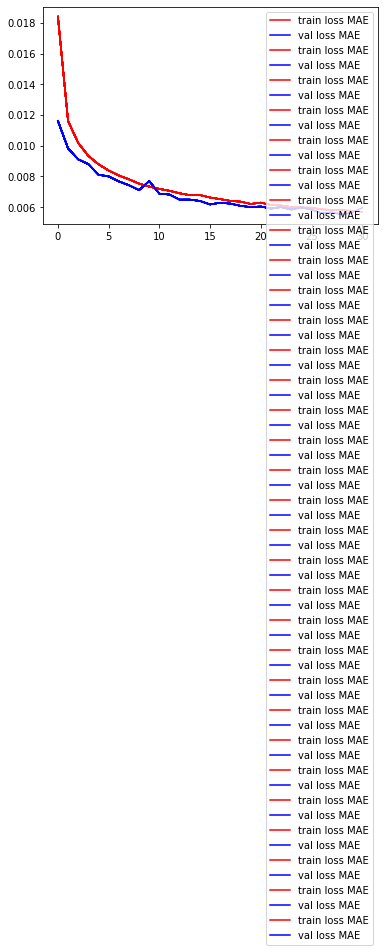

In [28]:
## create data generator, train model and save model.
BG = BatchGenerator()
print("here1")
MT = ModelTrainer()
print("here2")
MT.train_full_model()
print("finished training")
torch.save(MT.strongest_model, model_path + "trained_model_10steppred")
model = torch.load(model_path + "trained_model_10steppred")
model.eval()
print("saved the model")

from twilio.rest import Client
account_sid = "ACbb524ad1deed7bd1d53d2be7dd189de6"
auth_token = "9a0a01cddac5b0c827eb89a534fa897e"
client = Client(account_sid, auth_token)
FROM_NUM        = "+12562861398"
VERIFIED_NUMBER = "+447722355970"
message = client.messages.create(body='TESTING', from_=[FROM_NUM], to=[VERIFIED_NUMBER])
print(message.sid)

In [29]:
# test model on the full test sample:
BG = BatchGenerator()
model = torch.load(model_path + "trained_model_10steppred")
model.eval()

criterion1 = nn.L1Loss()
criterion2 = nn.MSELoss()
BG = BatchGenerator()
train_full_loader, valid_full_loader, test_full_loader = BG.load_full_data()

test_lossesMAE_t1 = 0.0
test_lossesMAE_t5 = 0.0
test_lossesMAE_t10 = 0.0
test_lossesMAE_scaled = 0.0
test_lossesMAE_t15 = 0.0
test_lossesMAE_t20 = 0.0
test_lossesMAE_t25 = 0.0
test_lossesMAE_t35 = 0.0
test_lossesMAE_t40 = 0.0
test_lossesMAE_t48 = 0.0

tactile_gt_test = []
tactile_gt_d1_test = []
tactile_gt_d2_test = []
action_test = []

tactile_predictions = []
tactile_groundtruth = []
experiment_time_steps = []
test_lossesMAE = 0.0
test_lossesMSE = 0.0
with torch.no_grad():
    for index__, batch_features in enumerate(test_full_loader):
        # 2. Reshape data and send to device:
        action = batch_features[0].squeeze(-1).permute(1,0,2).to(device)
        tactile = batch_features[1].permute(1,0,2).to(device)
        tactilederiv1 = batch_features[2].unsqueeze(2).permute(1,0,2).to(device)
        tactilederiv2 = batch_features[3].unsqueeze(2).permute(1,0,2).to(device)
        tp = model.forward(tactiles=tactile, actions=action, tac_deriv1=tactilederiv1, tac_deriv2=tactilederiv2) # Step 3. Run our forward pass.
        experiment_time_steps.append([batch_features[-2], batch_features[-1]])
        tp = tp[:,:,:48]
        ############ RESCALE THE DATA HERE ################
        tp_back_scaled = []
        tg_back_scaled = []
        for i in range(len(tp)+1):
            if scale_together == False:
                if i is not 0:
                    # tp:
                    (tpx, tpy, tpz) = np.split(tp[i-1].cpu().detach(), 3, axis=1)
                    xela_x_inverse_minmax = min_max_scalerx_full_data.inverse_transform(tpx)
                    xela_y_inverse_minmax = min_max_scalery_full_data.inverse_transform(tpy)
                    xela_z_inverse_minmax = min_max_scalerz_full_data.inverse_transform(tpz)
                    xela_x_inverse_full = scaler_tx.inverse_transform(xela_x_inverse_minmax)
                    xela_y_inverse_full = scaler_ty.inverse_transform(xela_y_inverse_minmax)
                    xela_z_inverse_full = scaler_tz.inverse_transform(xela_z_inverse_minmax)
                    tp_back_scaled.append(np.concatenate((xela_x_inverse_full,
                                                         xela_y_inverse_full,
                                                         xela_z_inverse_full), axis=1))
                # tg:
                (tpx, tpy, tpz) = np.split(tactile[context_frames-1:][i].cpu().detach(), 3, axis=1)
                xela_x_inverse_minmax = min_max_scalerx_full_data.inverse_transform(tpx)
                xela_y_inverse_minmax = min_max_scalery_full_data.inverse_transform(tpy)
                xela_z_inverse_minmax = min_max_scalerz_full_data.inverse_transform(tpz)
                xela_x_inverse_full = scaler_tx.inverse_transform(xela_x_inverse_minmax)
                xela_y_inverse_full = scaler_ty.inverse_transform(xela_y_inverse_minmax)
                xela_z_inverse_full = scaler_tz.inverse_transform(xela_z_inverse_minmax)
                tg_back_scaled.append(np.concatenate((xela_x_inverse_full,
                                                     xela_y_inverse_full,
                                                      xela_z_inverse_full), axis=1))
            else:
                tactile_prediction_decoded = min_max_scaler_xela_sensor1_principle_components.inverse_transform(tp[i].cpu().detach())
                tp_back_scaled.append(scaler_full.inverse_transform(tactile_prediction_decoded))
                tactile_gt_decoded = min_max_scaler_xela_sensor1_principle_components.inverse_transform(tactile[context_frames:][i].cpu().detach())
                tg_back_scaled.append(scaler_full.inverse_transform(tactile_gt_decoded))


        tp_back_scaled = torch.from_numpy(np.asarray(tp_back_scaled))
        tg_back_scaled = torch.from_numpy(np.asarray(tg_back_scaled))
        tactile_predictions.append(tp_back_scaled)
        tactile_groundtruth.append(tg_back_scaled)
        
        # for extended time step testing
        tactile_gt_test.append(tactile)
        tactile_gt_d1_test.append(tactilederiv1)
        tactile_gt_d2_test.append(tactilederiv2)
        action_test.append(action)

        # calculate losses for specific timesteps
        test_lossesMAE_scaled += criterion1(tp, tactile[context_frames:]).item()
        test_lossesMAE += criterion1(tp_back_scaled, tg_back_scaled[1:]).item()
        test_lossMAE_t1 = criterion1(tp_back_scaled[0,:,:], tg_back_scaled[1,:,:])
        test_lossesMAE_t1 += test_lossMAE_t1.item()
        test_lossMAE_t5 = criterion1(tp_back_scaled[4,:,:], tg_back_scaled[5,:,:])
        test_lossesMAE_t5 += test_lossMAE_t5.item()
        test_lossMAE_t10 = criterion1(tp_back_scaled[9,:,:], tg_back_scaled[10,:,:])
        test_lossesMAE_t10 += test_lossMAE_t10.item()
#         test_lossMAE_t15 = criterion1(tp_back_scaled[14,:,:], tg_back_scaled[15,:,:])
#         test_lossesMAE_t15 += test_lossMAE_t15.item()
#         test_lossMAE_t20 = criterion1(tp_back_scaled[19,:,:], tg_back_scaled[20,:,:])
#         test_lossesMAE_t20 += test_lossMAE_t20.item()
#         test_lossMAE_t25 = criterion1(tp_back_scaled[24,:,:], tg_back_scaled[25,:,:])
#         test_lossesMAE_t25 += test_lossMAE_t25.item()
#         test_lossMAE_t35 = criterion1(tp_back_scaled[34,:,:], tg_back_scaled[35,:,:])
#         test_lossesMAE_t35 += test_lossMAE_t35.item()
#         test_lossMAE_t40 = criterion1(tp_back_scaled[39,:,:], tg_back_scaled[40,:,:])
#         test_lossesMAE_t40 += test_lossMAE_t40.item()
#         test_lossMAE_t48 = criterion1(tp_back_scaled[47,:,:], tg_back_scaled[48,:,:])
#         test_lossesMAE_t48 += test_lossMAE_t48.item()

performance_data = []
performance_data.append(["unscaled test loss MAE(L1): ", (test_lossesMAE_scaled / index__)])
performance_data.append(["test loss MAE(L1): ", (test_lossesMAE / index__)])
performance_data.append(["test loss MAE(L1) timestep 1: ", (test_lossesMAE_t1 / index__)])
performance_data.append(["test loss MAE(L1) timestep 5: ", (test_lossesMAE_t5 / index__)])
performance_data.append(["test loss MAE(L1) timestep 10: ", (test_lossesMAE_t10 / index__)])
# performance_data.append(["test loss MAE(L1) timestep 15: ", (test_lossesMAE_t15 / index__)])
# performance_data.append(["test loss MAE(L1) timestep 20: ", (test_lossesMAE_t20 / index__)])
# performance_data.append(["test loss MAE(L1) timestep 25: ", (test_lossesMAE_t25 / index__)])
# performance_data.append(["test loss MAE(L1) timestep 35: ", (test_lossesMAE_t35 / index__)])
# performance_data.append(["test loss MAE(L1) timestep 40: ", (test_lossesMAE_t40 / index__)])
# performance_data.append(["test loss MAE(L1) timestep 48: ", (test_lossesMAE_t48 / index__)])
[print(i) for i in performance_data]

np.save(model_path + 'performance_data10step', np.asarray(performance_data))

/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/

/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/

/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/

/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/

/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/

/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/

/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/

/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/

/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/

/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/

/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/

/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/

['unscaled test loss MAE(L1): ', 0.008181388550297939]
['test loss MAE(L1): ', 85.65947436908704]
['test loss MAE(L1) timestep 1: ', 58.05104889714715]
['test loss MAE(L1) timestep 5: ', 82.28611971858432]
['test loss MAE(L1) timestep 10: ', 104.60656729385352]


/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/

In [ ]:
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
# calculate tactile values for full sample:
time_step_to_test_t1 = 0    # [batch_set, prediction frames(t1->tx)(6), batch_size, features(48)]
time_step_to_test_t5 = 4
time_step_to_test_t9 = 9
predicted_data_t1 = []
predicted_data_t5 = []
predicted_data_t9 = []
groundtruth_data = []
time_stepsto_plot = []
test_t = []
test_d1 = []
test_d2 = []
test_a = []
experiment_to_test = len(p) - 1  # experiment 106 as its the last one

for batchset in range(len(tactile_predictions)):
    for batch in range(len(tactile_predictions[batchset][time_step_to_test_t9])):
        experiment = experiment_time_steps[batchset][0][batch][0].numpy()
        time_step = experiment_time_steps[batchset][1][batch][0].numpy()
        if experiment == experiment_to_test:
            predicted_data_t1.append(tactile_predictions[batchset][time_step_to_test_t1][batch])
            predicted_data_t5.append(tactile_predictions[batchset][time_step_to_test_t5][batch])
            predicted_data_t9.append(tactile_predictions[batchset][time_step_to_test_t9][batch])
            groundtruth_data.append(tactile_groundtruth[batchset][0][batch])
            time_stepsto_plot.append(time_step.item())
# print(aaaa)
# for index, batch_set in enumerate(tactile_predictions):
#     for batch in range(0, len(batch_set[0])):
#         experiment = experiment_time_steps[index][0][batch][0].numpy()
#         time_step = experiment_time_steps[index][1][batch][0].numpy()
#         if experiment == experiment_to_test:
#             predicted_data_t1.append(batch_set[time_step_to_test_t1][batch])
#             predicted_data_t5.append(batch_set[time_step_to_test_t5][batch])
#             predicted_data_t9.append(batch_set[time_step_to_test_t9][batch])
#             groundtruth_data.append(tactile_groundtruth[index][time_step_to_test_t1][batch])
#             time_stepsto_plot.append(time_step.item())
# print(aaaaaa)


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

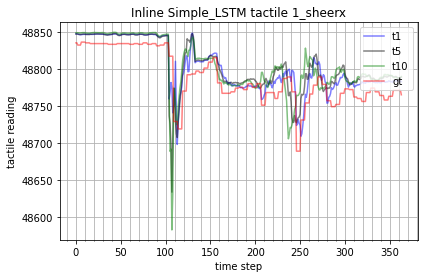

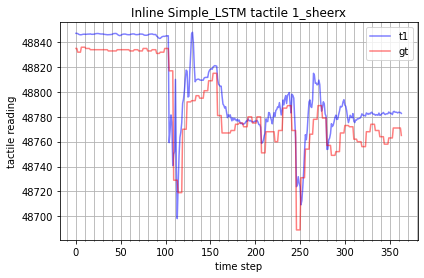

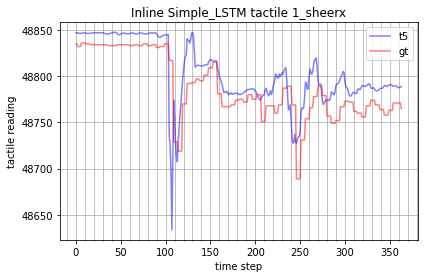

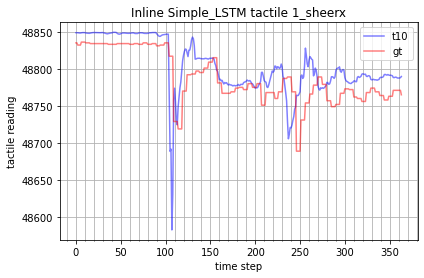

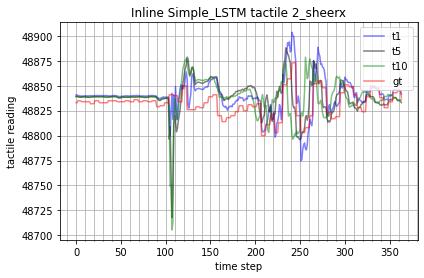

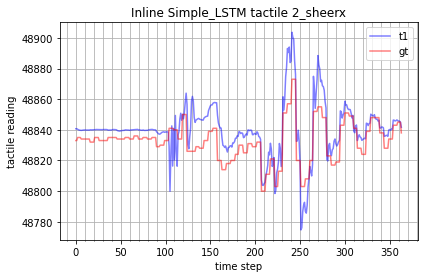

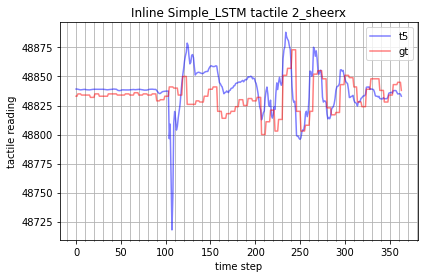

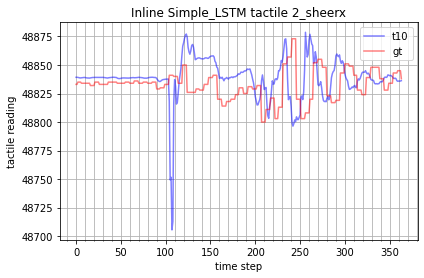

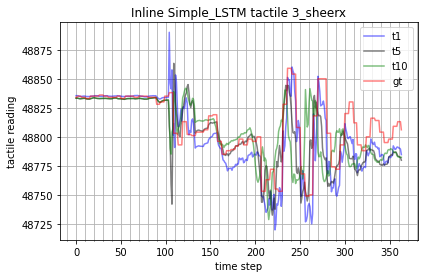

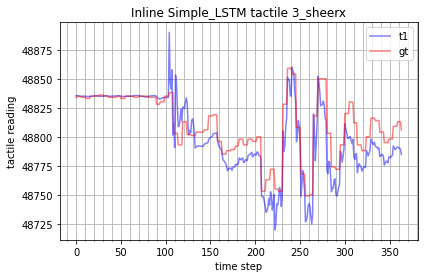

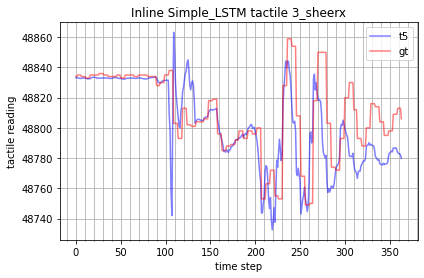

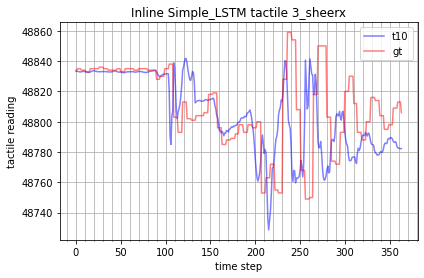

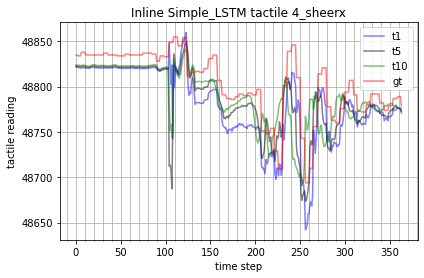

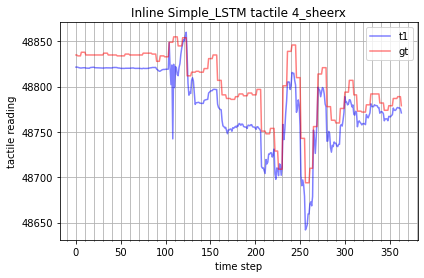

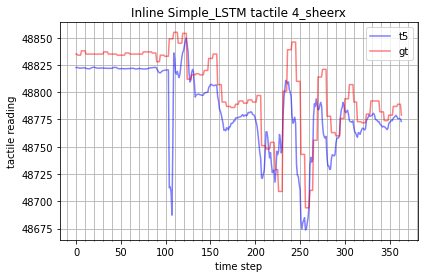

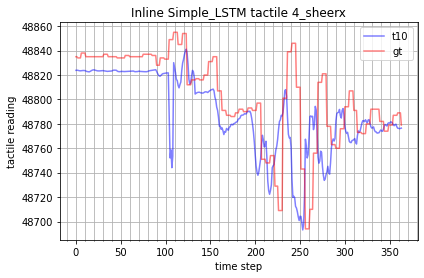

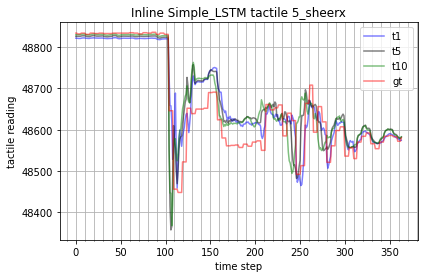

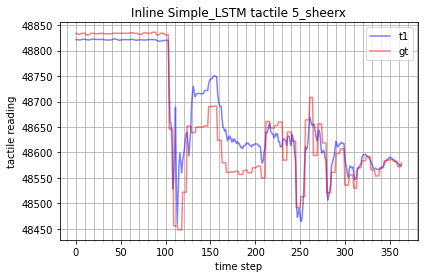

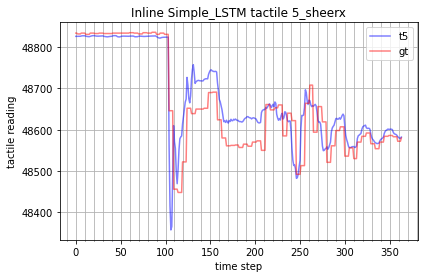

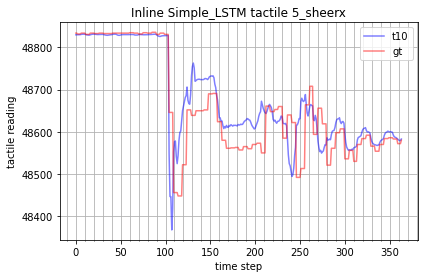

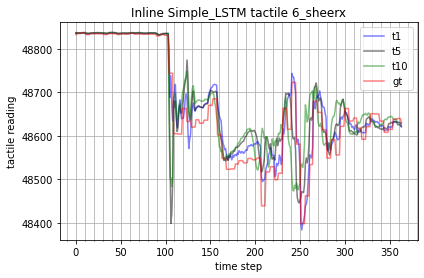

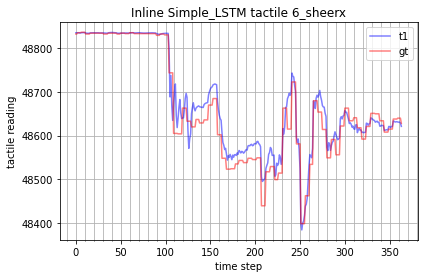

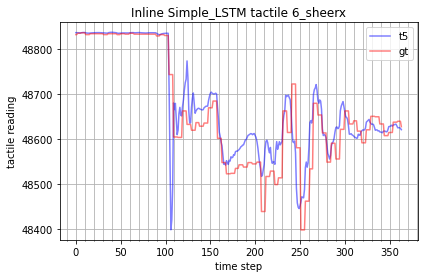

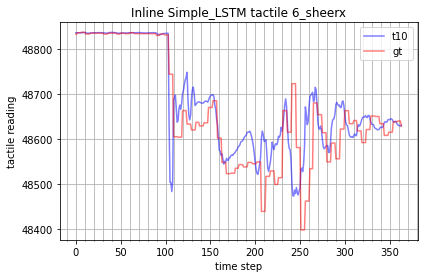

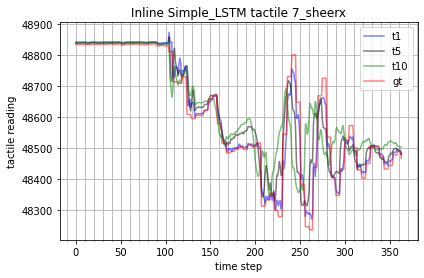

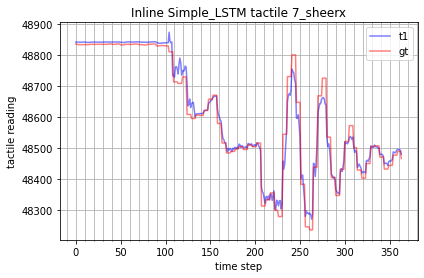

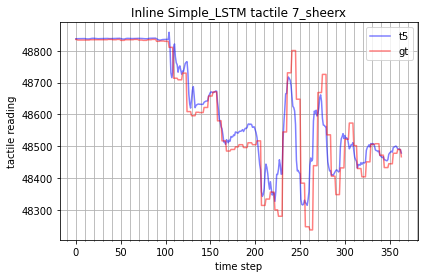

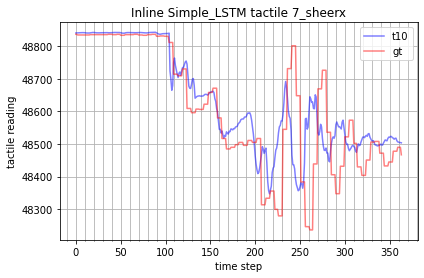

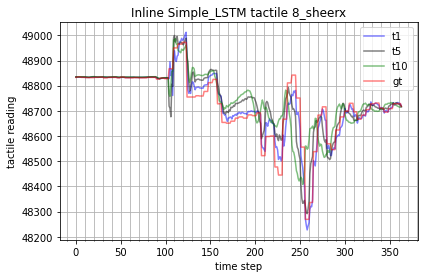

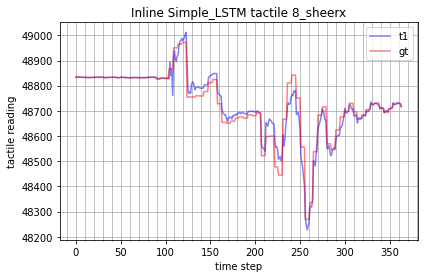

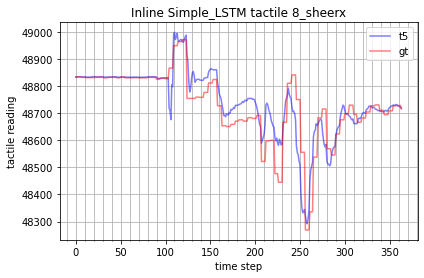

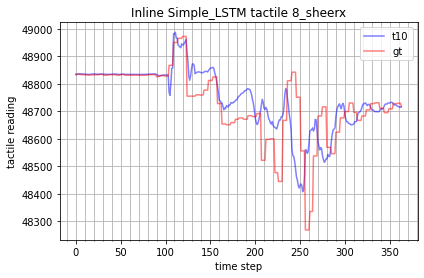

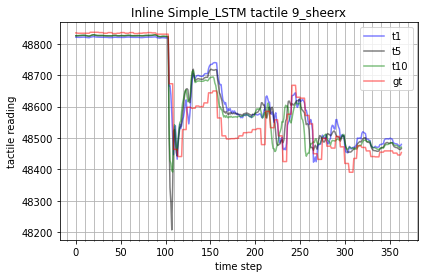

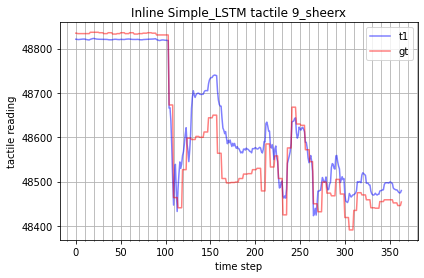

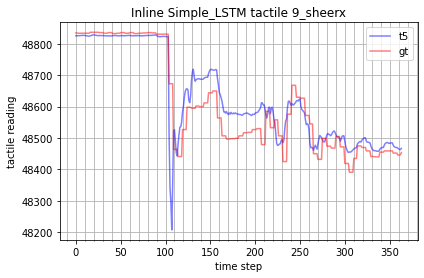

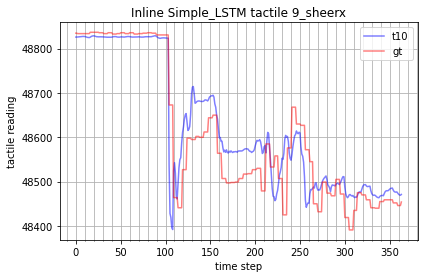

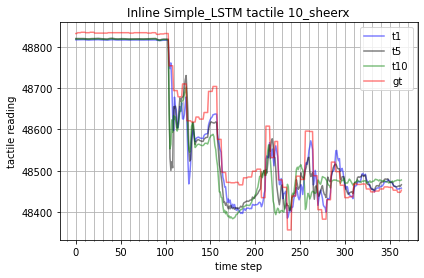

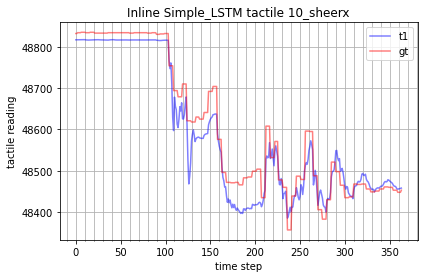

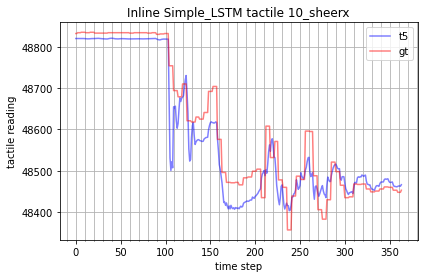

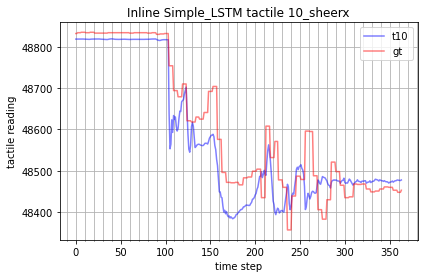

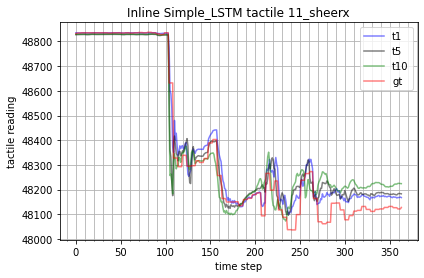

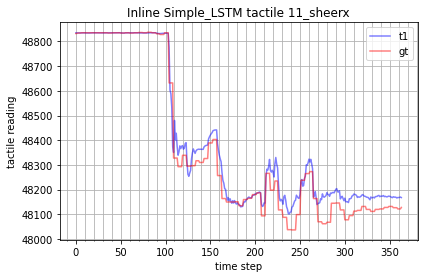

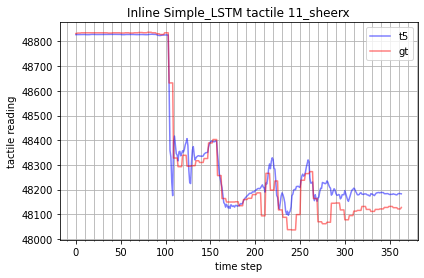

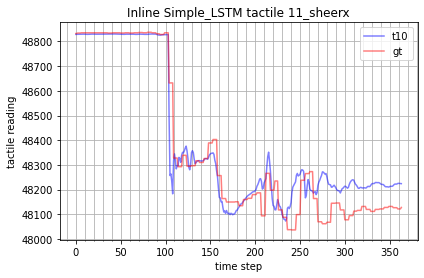

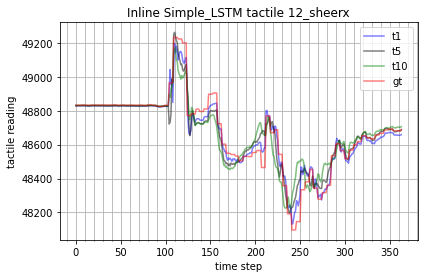

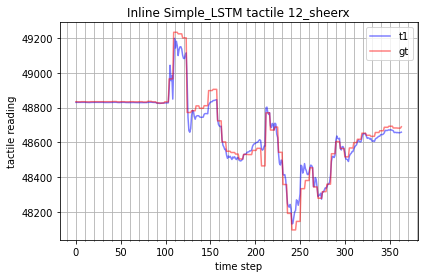

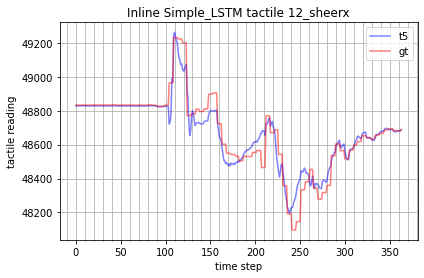

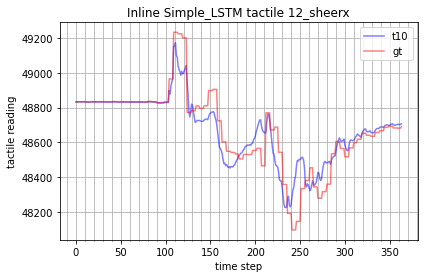

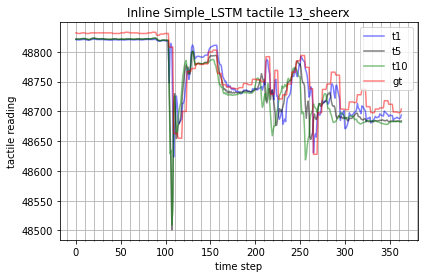

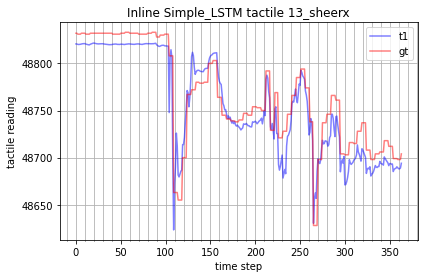

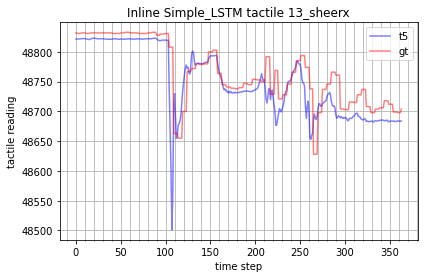

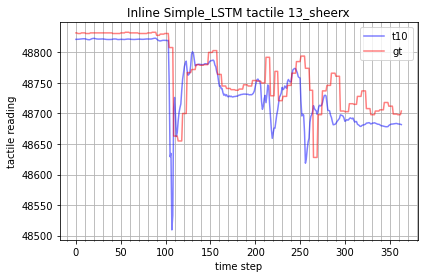

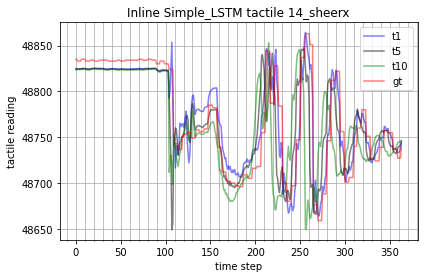

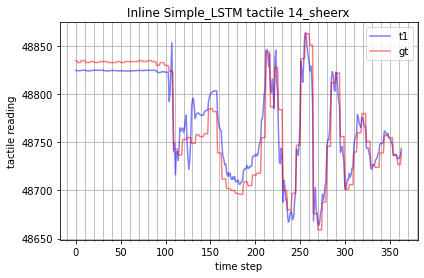

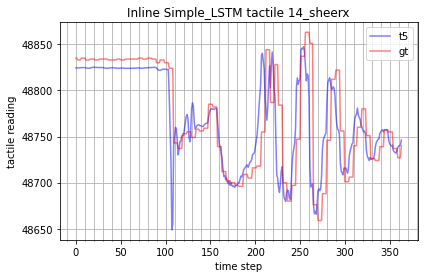

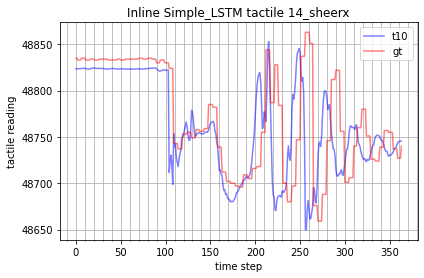

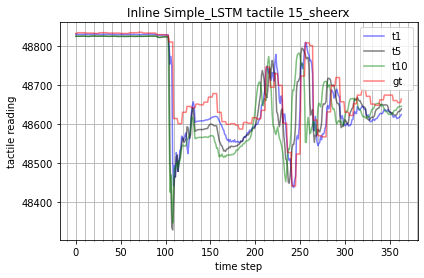

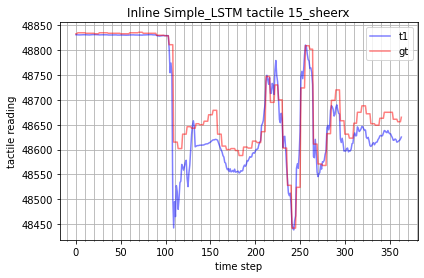

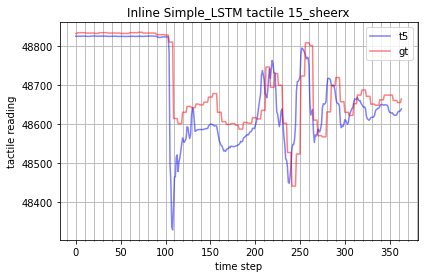

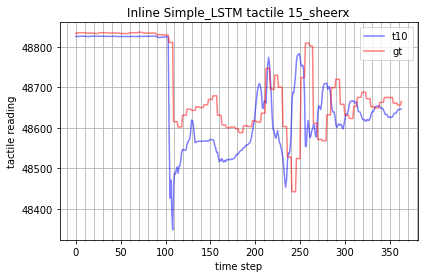

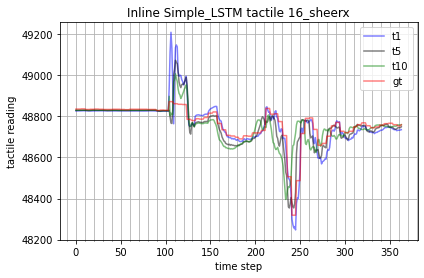

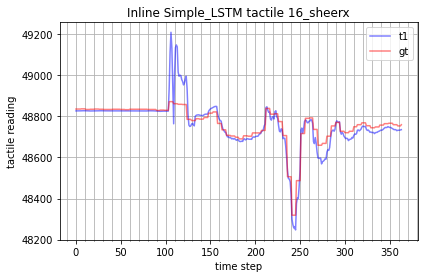

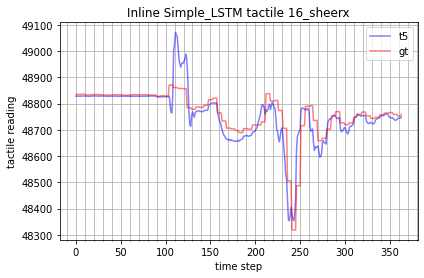

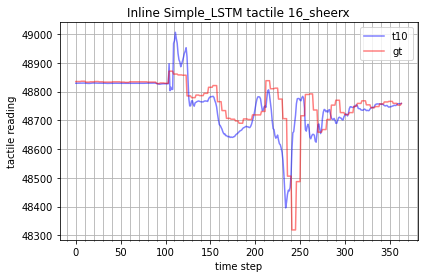

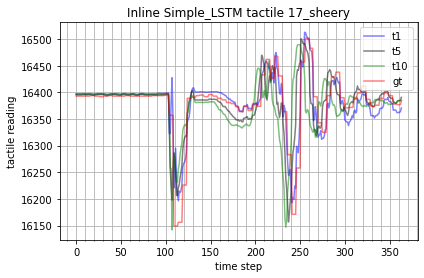

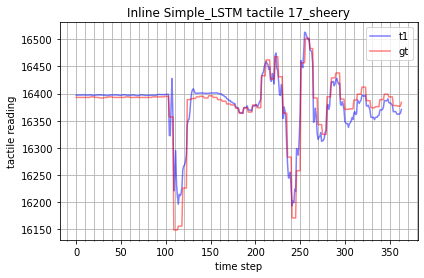

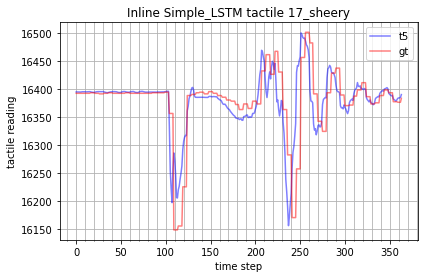

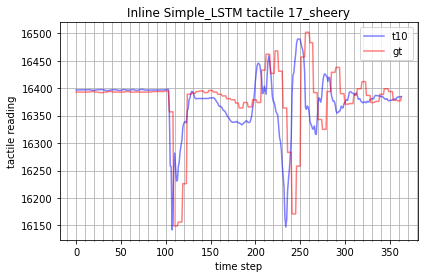

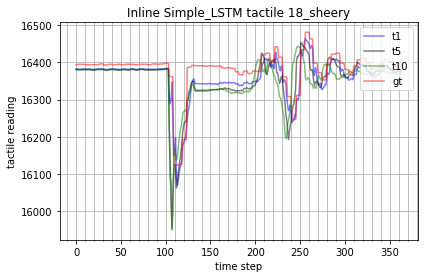

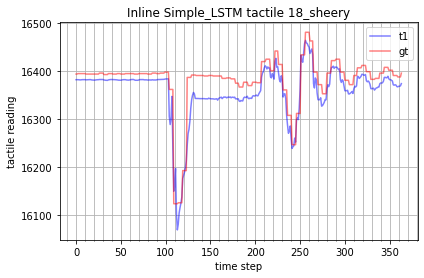

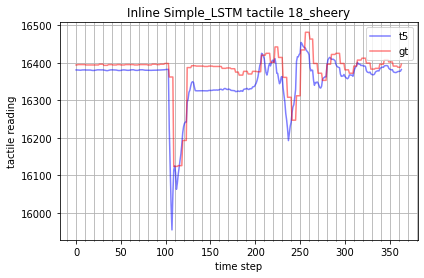

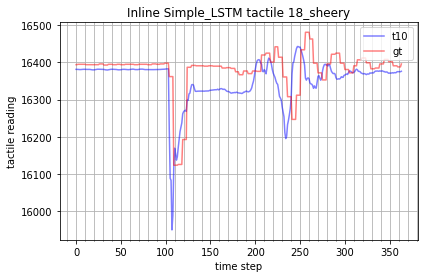

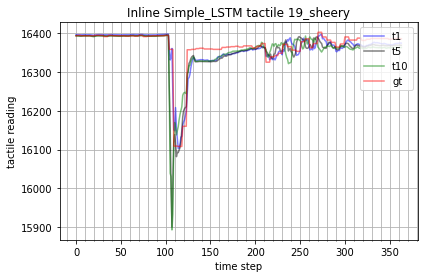

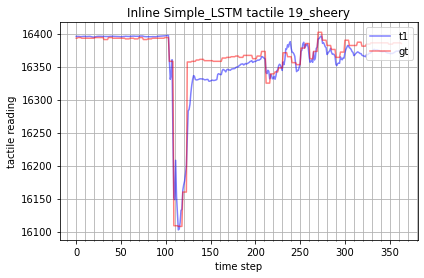

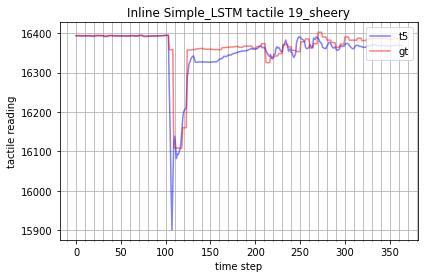

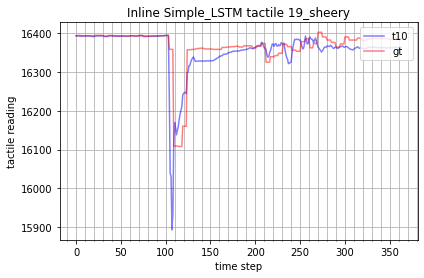

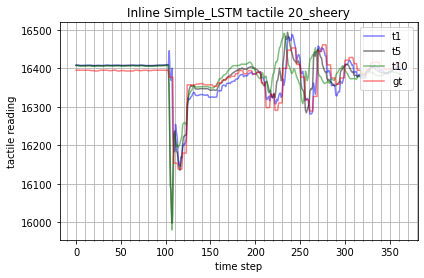

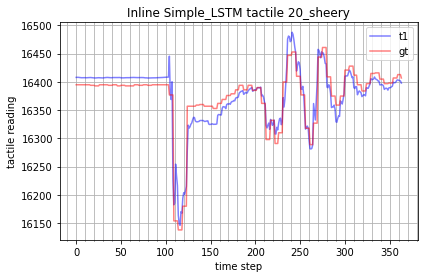

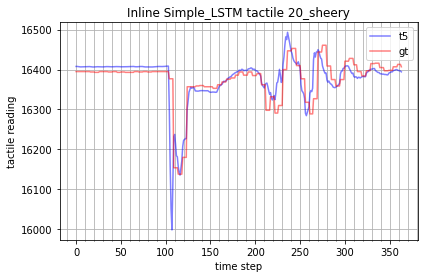

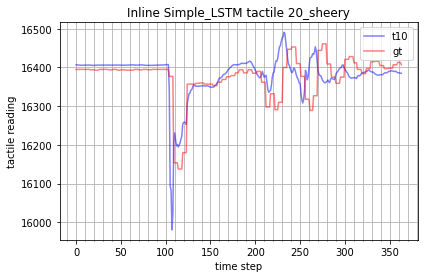

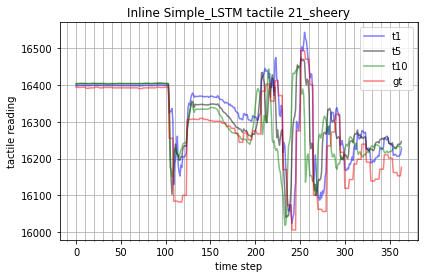

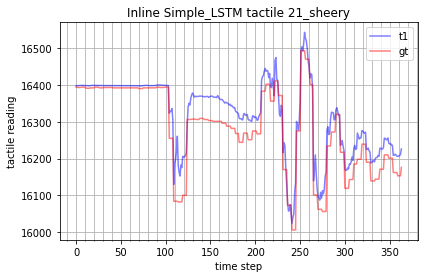

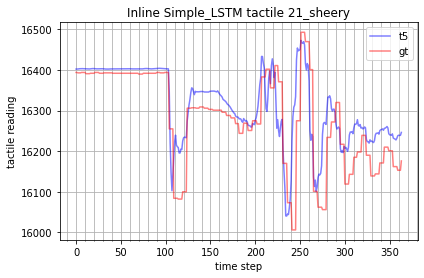

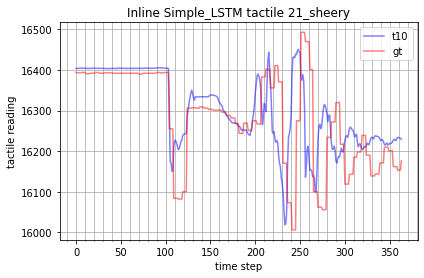

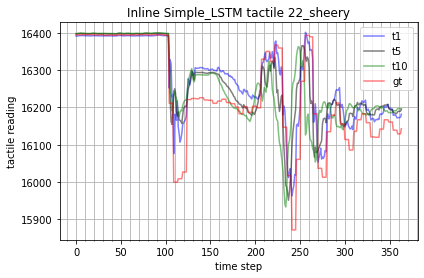

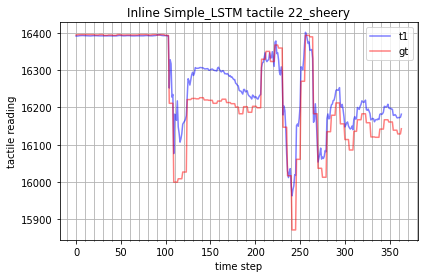

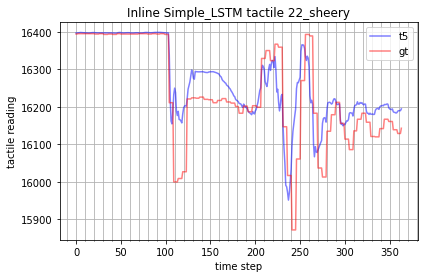

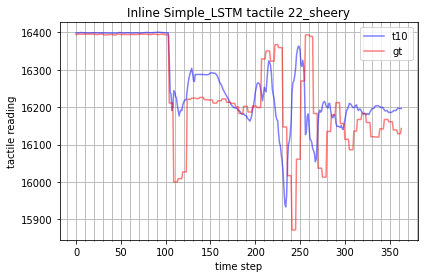

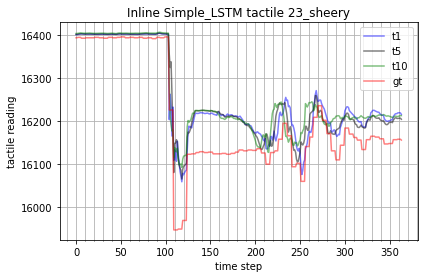

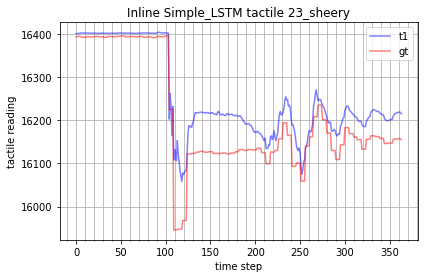

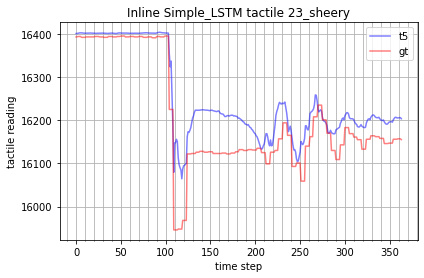

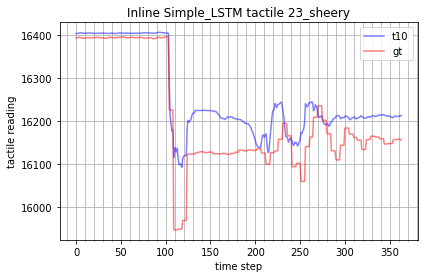

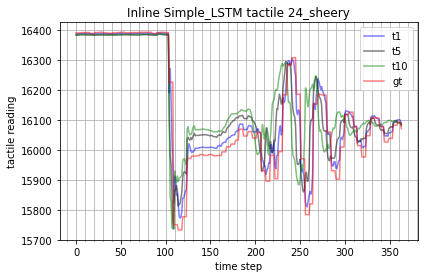

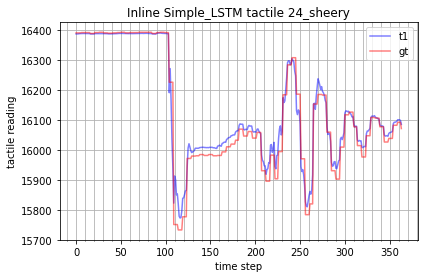

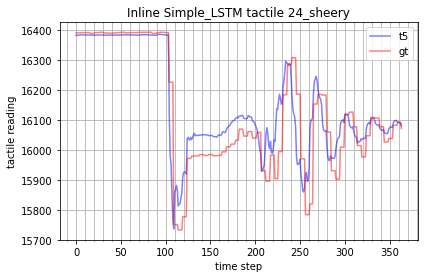

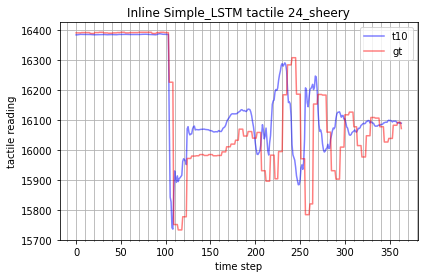

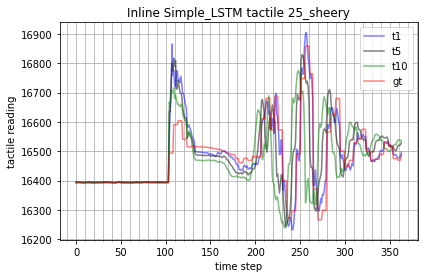

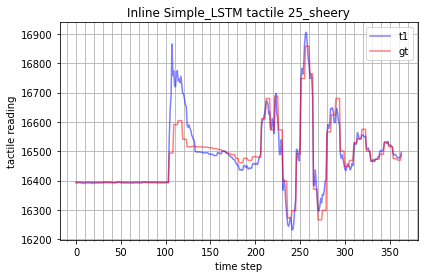

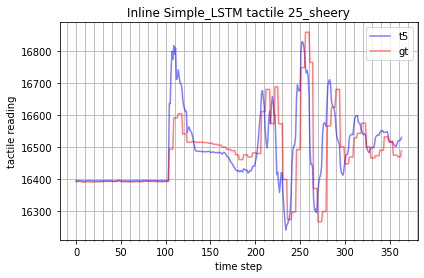

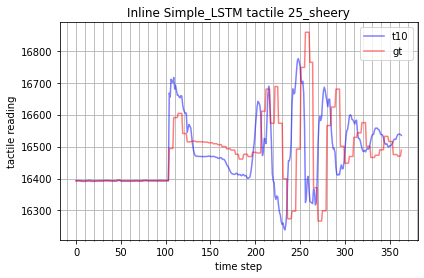

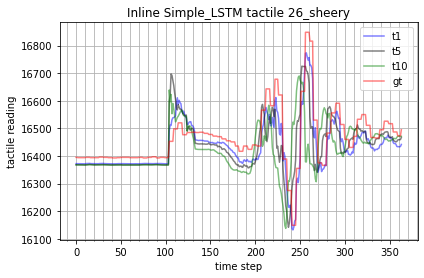

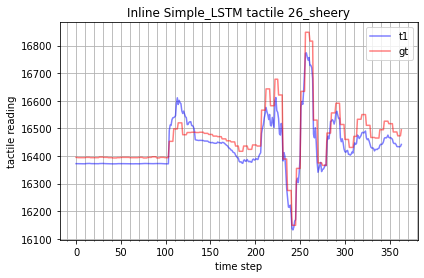

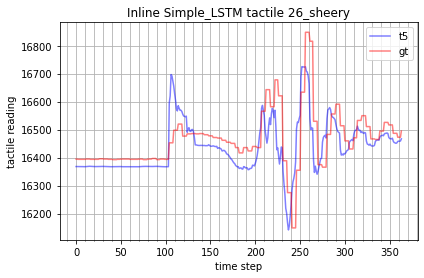

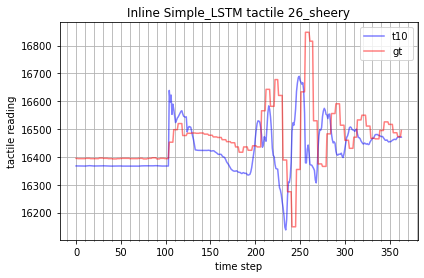

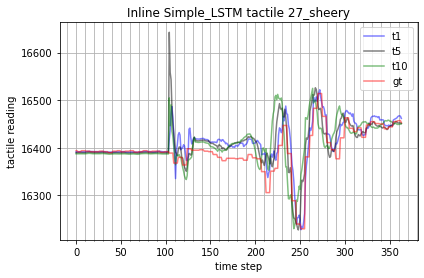

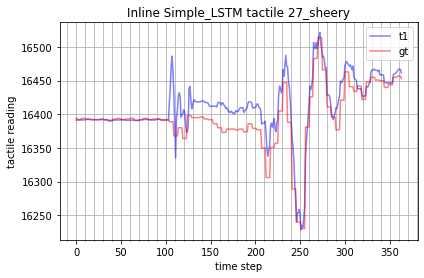

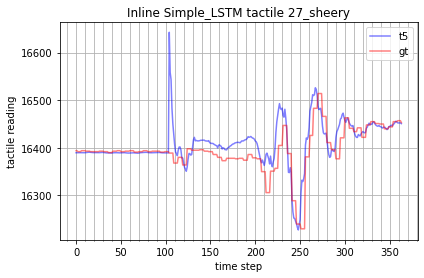

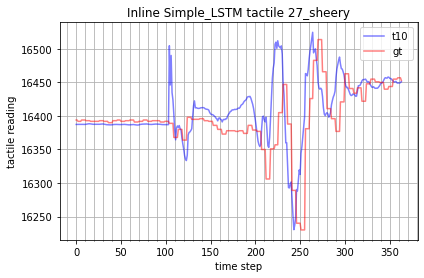

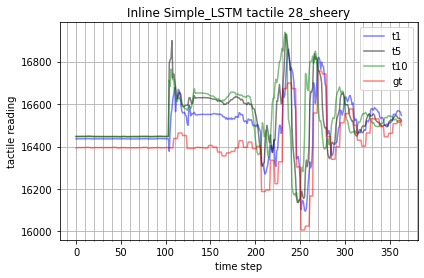

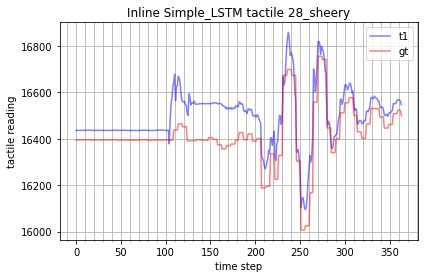

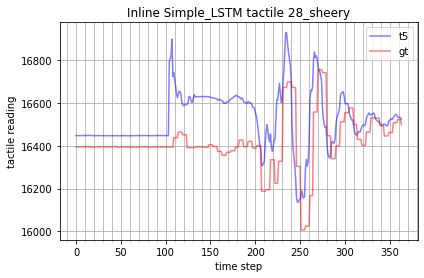

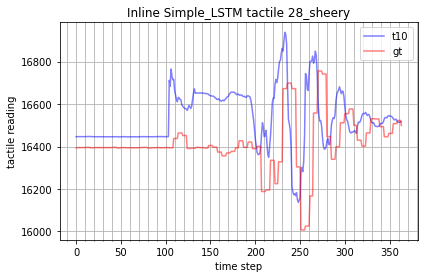

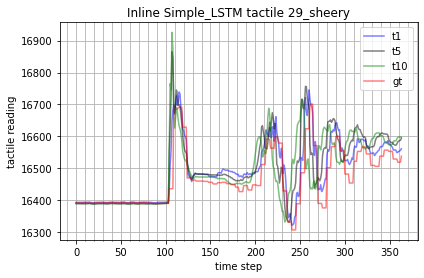

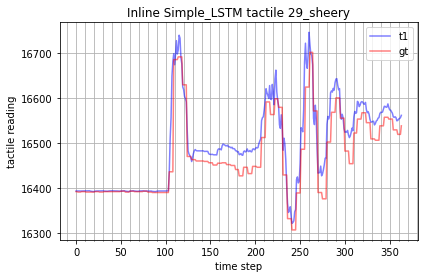

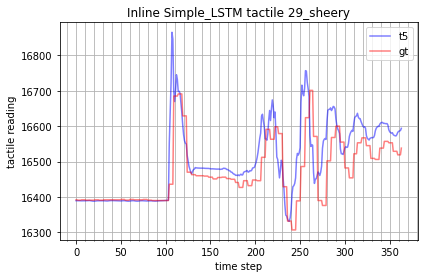

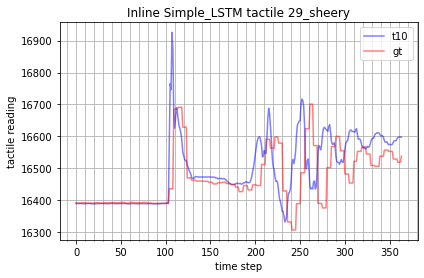

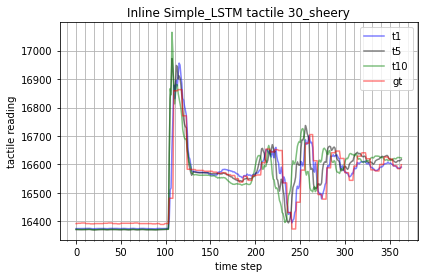

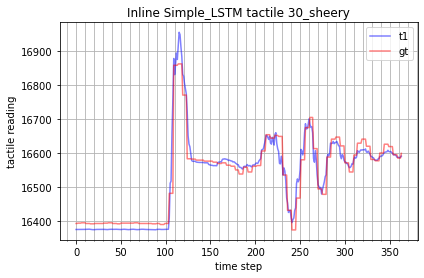

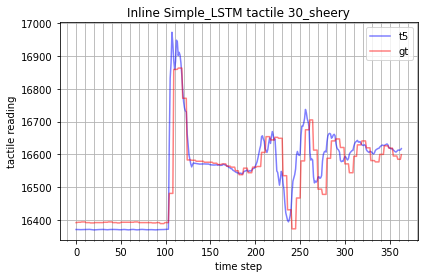

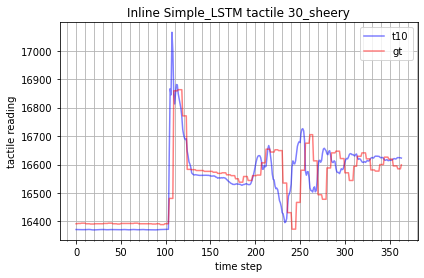

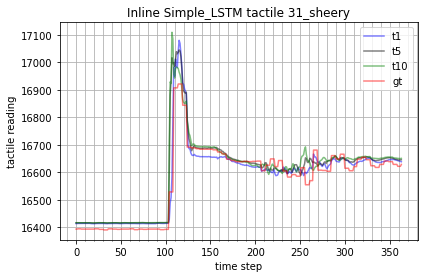

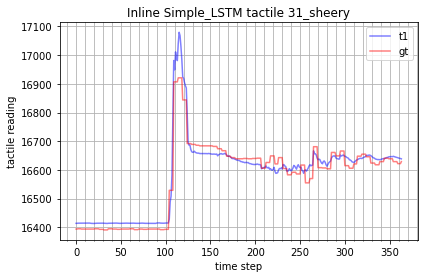

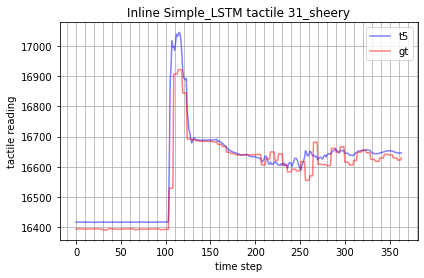

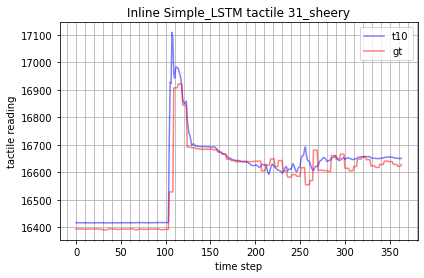

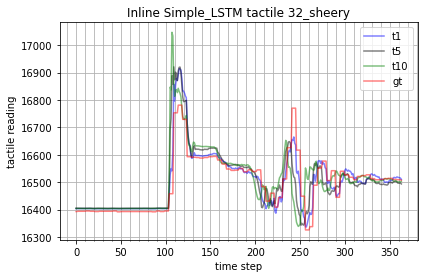

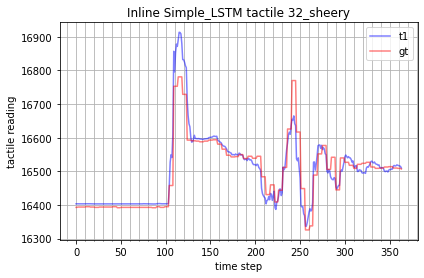

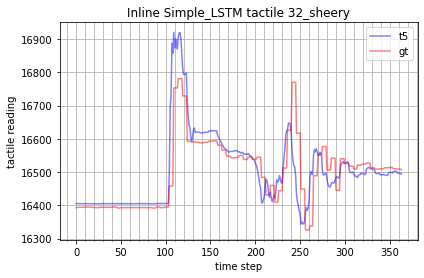

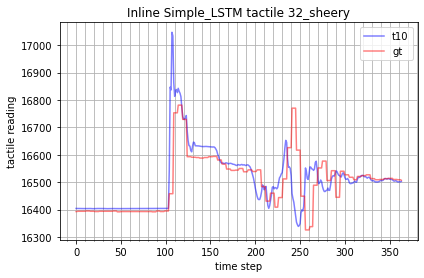

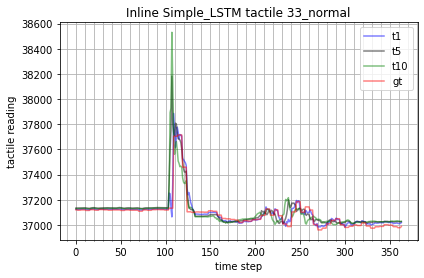

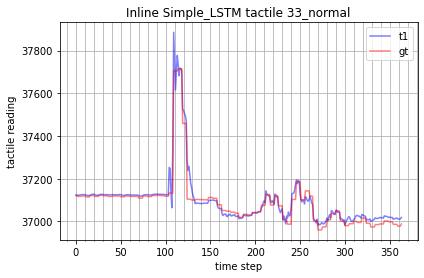

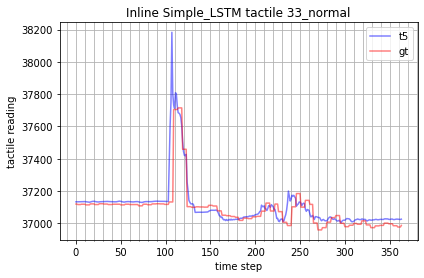

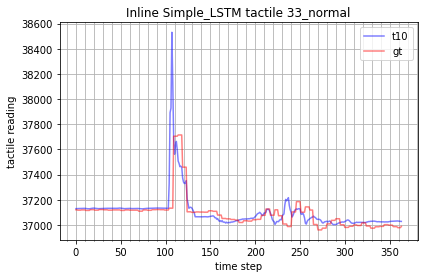

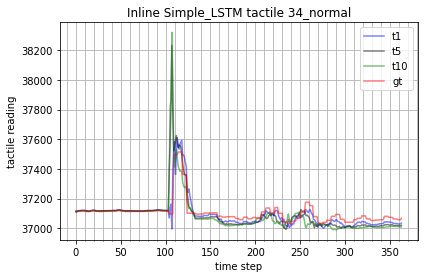

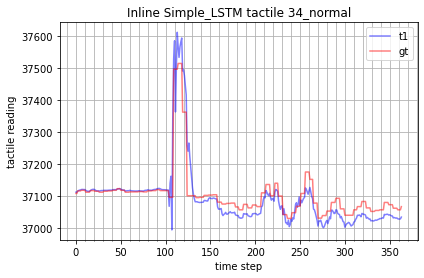

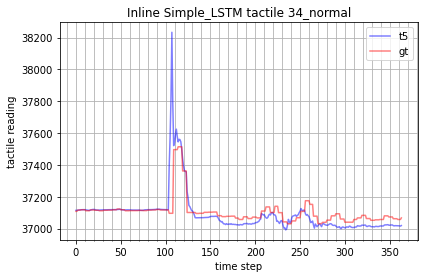

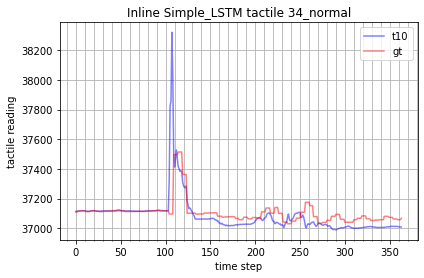

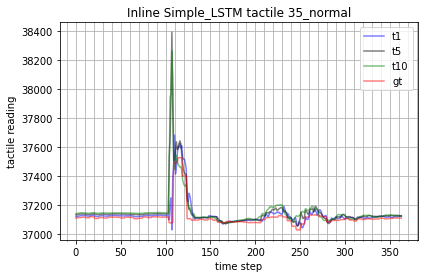

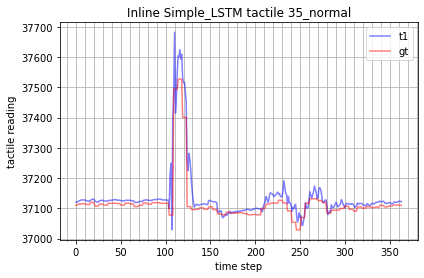

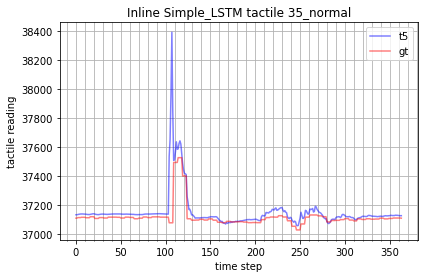

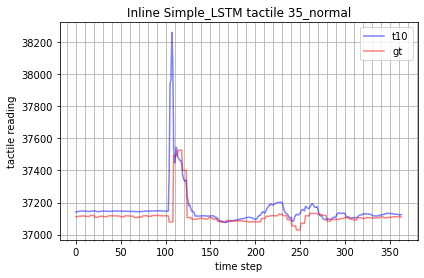

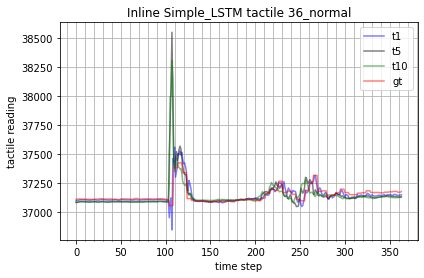

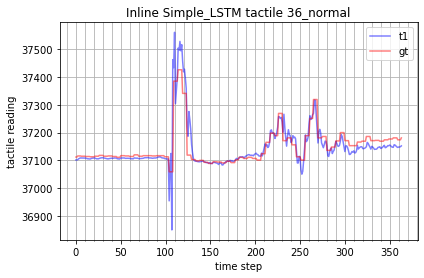

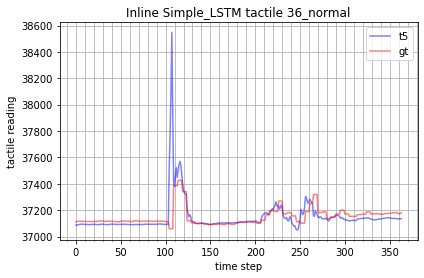

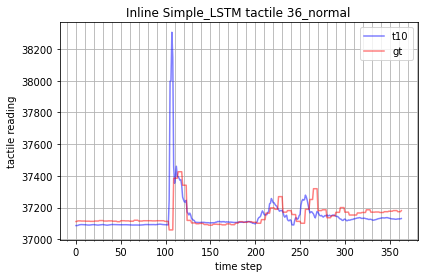

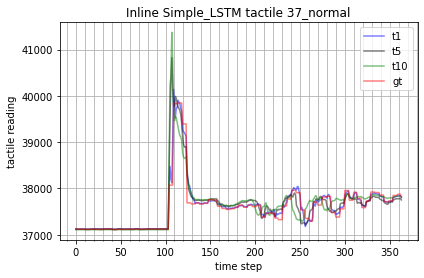

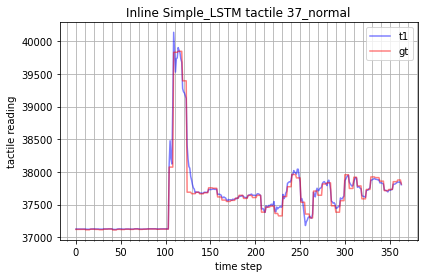

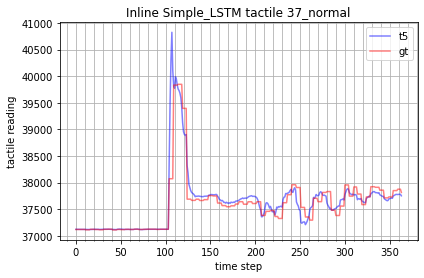

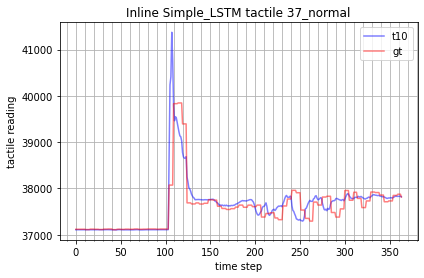

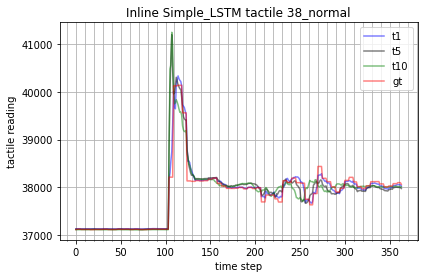

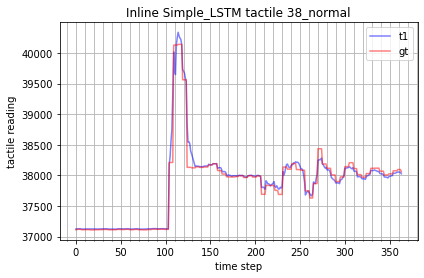

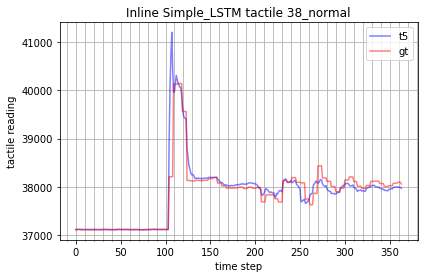

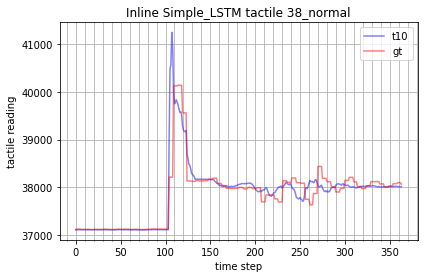

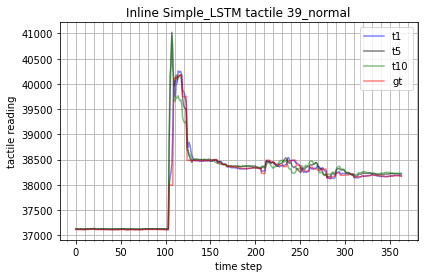

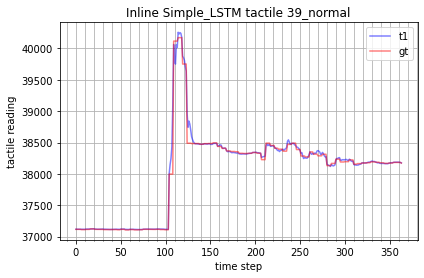

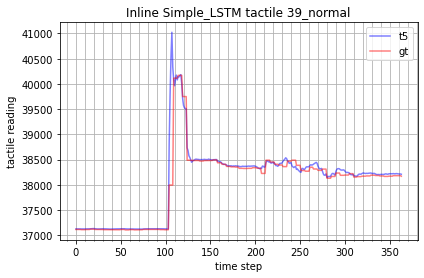

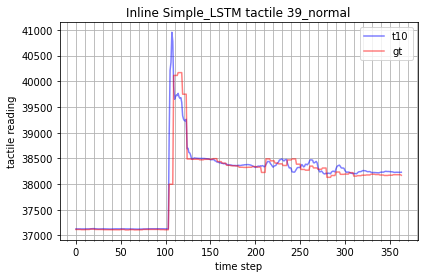

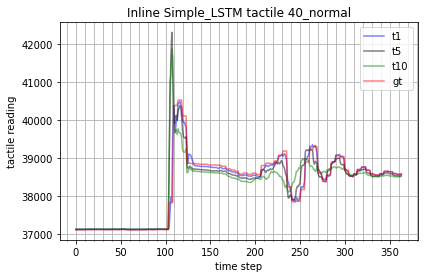

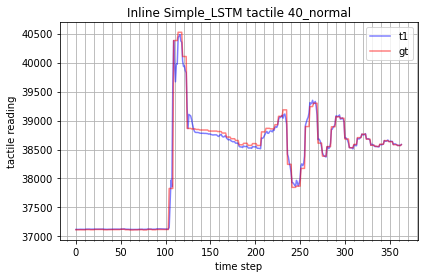

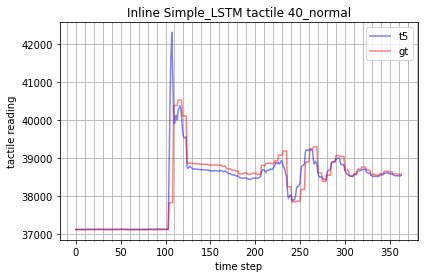

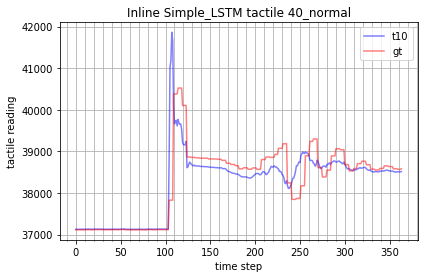

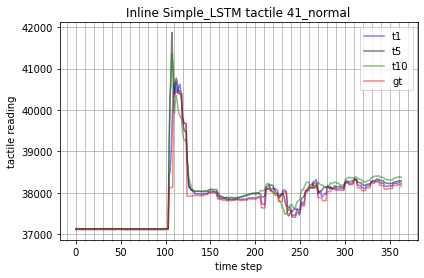

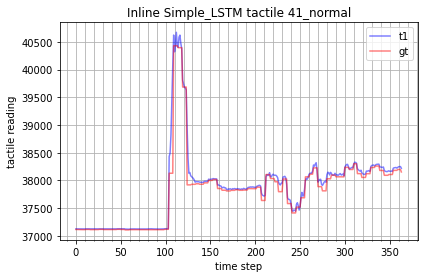

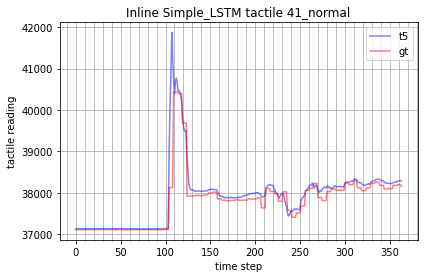

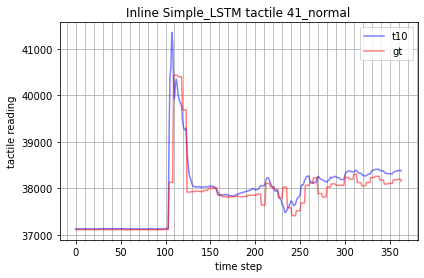

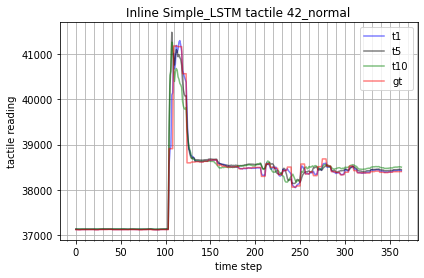

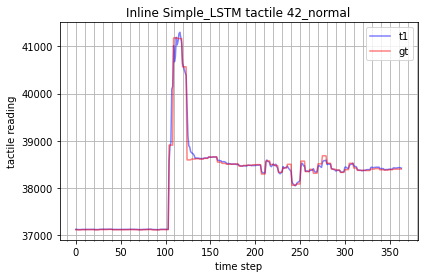

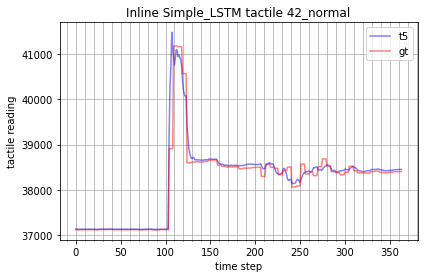

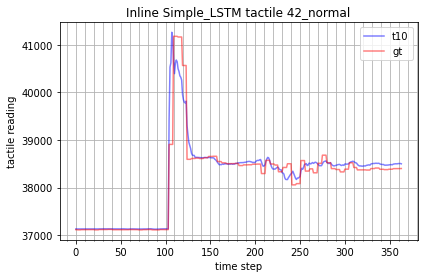

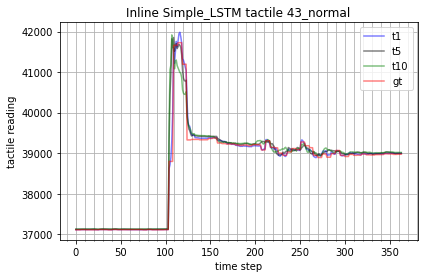

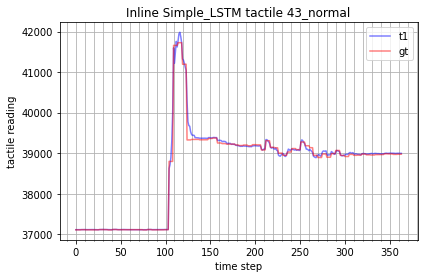

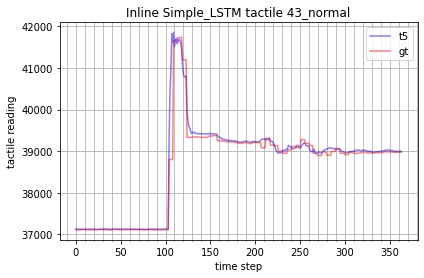

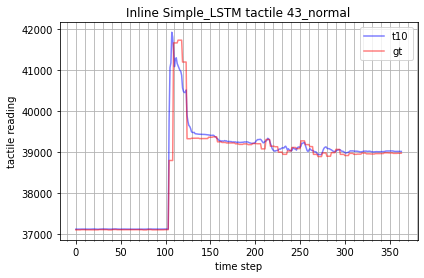

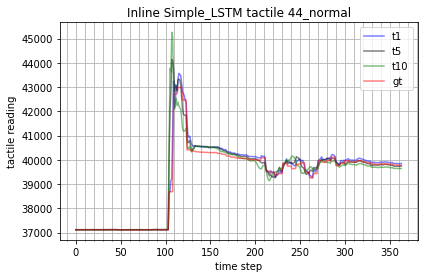

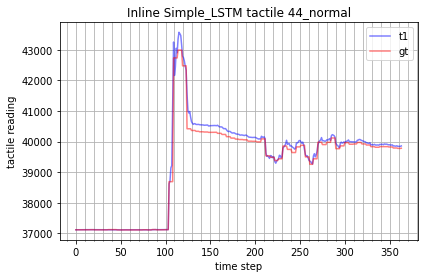

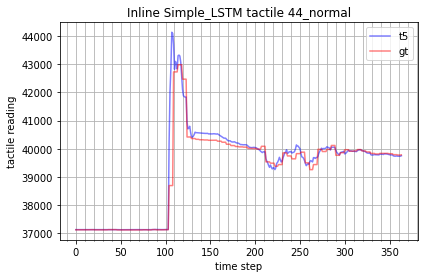

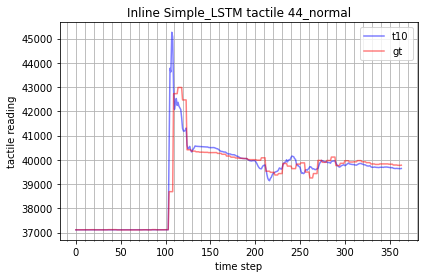

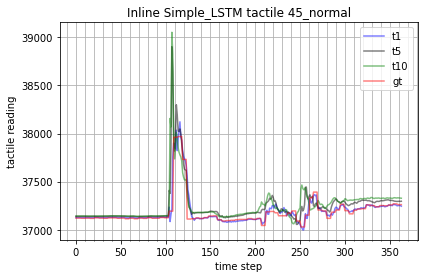

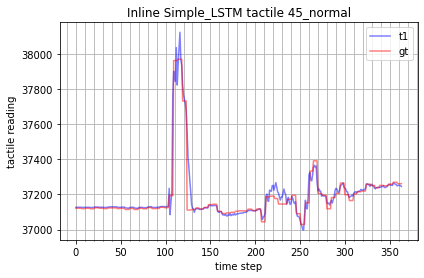

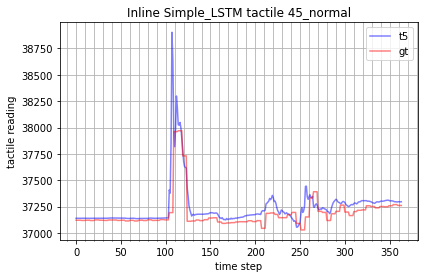

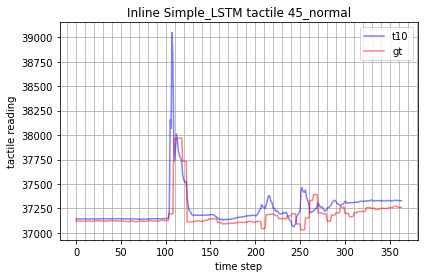

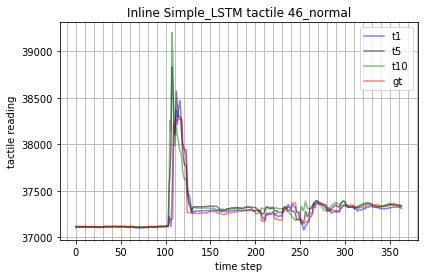

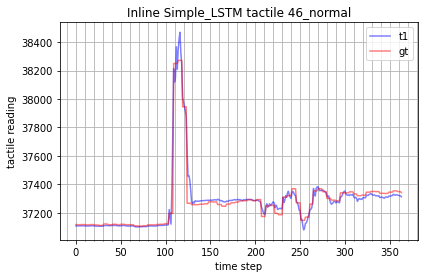

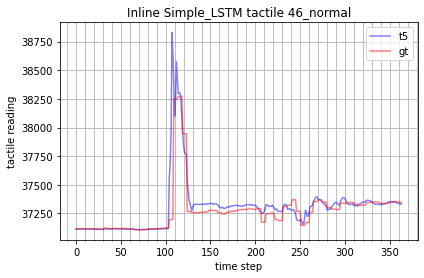

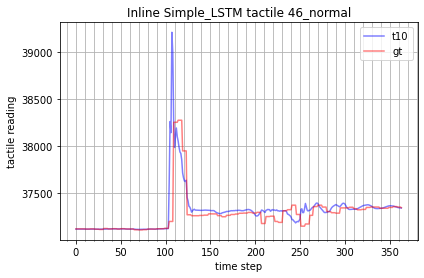

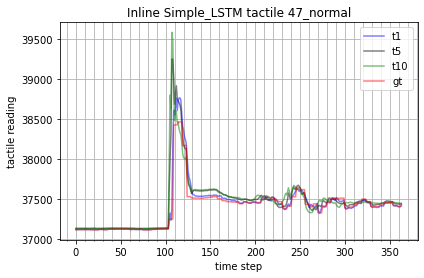

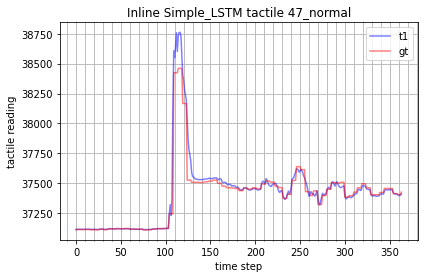

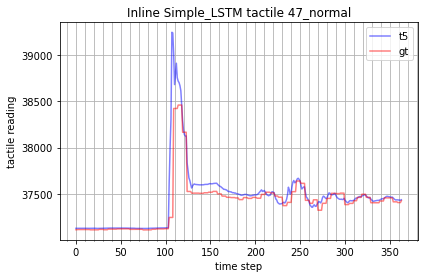

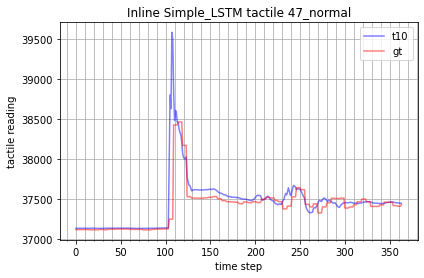

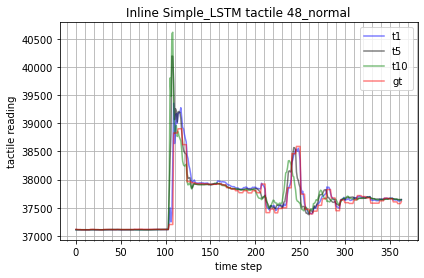

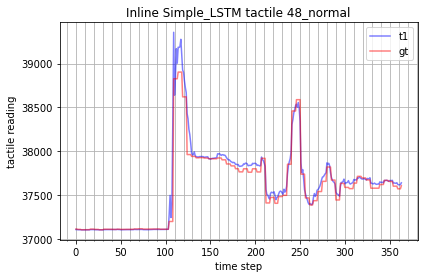

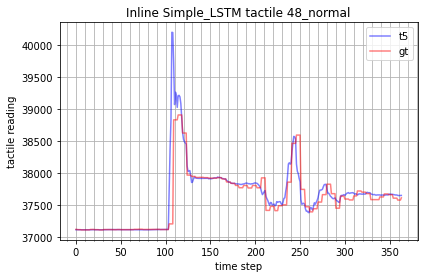

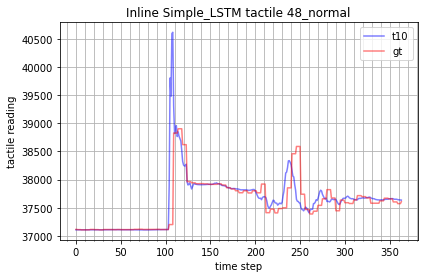

In [32]:
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
# calculate tactile values for full sample:
time_step_to_test_t1 = 0    # [batch_set, prediction frames(t1->tx)(6), batch_size, features(48)]
time_step_to_test_t5 = 4
time_step_to_test_t9 = 9
predicted_data_t1 = []
predicted_data_t5 = []
predicted_data_t9 = []
groundtruth_data = []
time_stepsto_plot = []
test_t = []
test_d1 = []
test_d2 = []
test_a = []
experiment_to_test = len(p) - 4  # experiment 106 as its the last one
for batchset in range(len(tactile_predictions)):
    for batch in range(len(tactile_predictions[batchset][time_step_to_test_t9])):
        experiment = experiment_time_steps[batchset][0][batch][0].numpy()
        time_step = experiment_time_steps[batchset][1][batch][0].numpy()
        if experiment == experiment_to_test:
            predicted_data_t1.append(tactile_predictions[batchset][time_step_to_test_t1][batch])
            predicted_data_t5.append(tactile_predictions[batchset][time_step_to_test_t5][batch])
            predicted_data_t9.append(tactile_predictions[batchset][time_step_to_test_t9][batch])
            groundtruth_data.append(tactile_groundtruth[batchset][0][batch])
            time_stepsto_plot.append(time_step.item())

# experiment_to_test = len(p) - 1  # experiment 106 as its the last one
# for index, batch_set in enumerate(tactile_predictions):
#     for batch in range(0, len(batch_set[0])):
#         experiment = experiment_time_steps[index][0][batch][0].numpy()
#         time_step = experiment_time_steps[index][1][batch][0].numpy()
#         if experiment == experiment_to_test:
#             predicted_data_t1.append(batch_set[time_step_to_test_t1][batch])
#             predicted_data_t5.append(batch_set[time_step_to_test_t5][batch])
#             predicted_data_t9.append(batch_set[time_step_to_test_t9][batch])
#             groundtruth_data.append(tactile_groundtruth[index][time_step_to_test_t1][batch])
#             time_stepsto_plot.append(time_step.item())
            
#             test_t.append(tactile_gt_test[index][time_step_to_test_t1][batch])
#             test_d1.append(tactile_gt_d1_test[index][time_step_to_test_t1][batch])
#             test_d2.append(tactile_gt_d2_test[index][time_step_to_test_t1][batch])
#             test_a.append(action_test[index][time_step_to_test_t1][batch])

# [108, data_sample_2021-03-26-09-45-38']
# [128, data_sample_2021-03-26-09-48-32']
# [193, data_sample_2021-03-26-09-40-56']
# order  = 108 128 193 106]
print(time_stepsto_plot)
# test data
index = 0
plot_range_start = 0 # 0
plot_range_stop  = len(time_stepsto_plot) # len(time_stepsto_plot)
experiment_to_test = 108
titles = ["sheerx", "sheery", "normal"]
for j in range(3):
    for i in range(16):
        groundtruth_taxle = []
        predicted_taxel = []
        predicted_taxel_t1 = []
        predicted_taxel_t5 = []
        predicted_taxel_t9 = []
        # good = 140, 145 (lifting up the )
        for k in range(plot_range_start, plot_range_stop):# len(predicted_data_t1)):#310, 325):#len(predicted_data_t1)):  # add in length of context data
            predicted_taxel_t1.append(predicted_data_t1[k][index].cpu().detach().numpy())
            predicted_taxel_t5.append(predicted_data_t5[k][index].cpu().detach().numpy())
            predicted_taxel_t9.append(predicted_data_t9[k][index].cpu().detach().numpy())
            groundtruth_taxle.append(groundtruth_data[k][index].cpu().detach().numpy())

        index += 1
        fig, ax1 = plt.subplots()
        ax1.set_xlabel('time step')
        ax1.set_ylabel('tactile reading')
        ax1.plot([value for value in time_stepsto_plot[plot_range_start:plot_range_stop]], [i for i in predicted_taxel_t1], alpha=0.5, c="b", label="t1")
        ax1.plot([value for value in time_stepsto_plot[plot_range_start:plot_range_stop]], [i for i in predicted_taxel_t5], alpha=0.5, c="k", label="t5")
        ax1.plot([value for value in time_stepsto_plot[plot_range_start:plot_range_stop]], [i for i in predicted_taxel_t9], alpha=0.5, c="g", label="t10")
        ax1.plot([value for value in time_stepsto_plot[plot_range_start:plot_range_stop]], groundtruth_taxle, alpha=0.5, c="r", label="gt")
        ax1.tick_params(axis='y')
        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        fig.subplots_adjust(top=0.90)
        ax1.legend(loc="upper right")
        
        ax1.xaxis.set_minor_locator(AutoMinorLocator())
        ax1.tick_params(which='minor', length=1, color='k')
        ax1.grid(which='minor')
        ax1.grid(which='major')
        
        plt.title("Inline Simple_LSTM tactile " + str(index) + "_" + titles[j])
        plt.savefig(model_path + '/' + str(experiment_to_test) + '/10step_prediction/timestep_' + str(plot_range_start) + "_" + str(plot_range_stop) + '_tactile_' + str(index) + '.png', dpi=300)
        plt.show()

        fig, ax1 = plt.subplots()
        ax1.set_xlabel('time step')
        ax1.set_ylabel('tactile reading')
        ax1.plot([value for value in time_stepsto_plot[plot_range_start:plot_range_stop]], [i for i in predicted_taxel_t1], alpha=0.5, c="b", label="t1")
        ax1.plot([value for value in time_stepsto_plot[plot_range_start:plot_range_stop]], groundtruth_taxle, alpha=0.5, c="r", label="gt")
        ax1.tick_params(axis='y')
        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        fig.subplots_adjust(top=0.90)
        ax1.legend(loc="upper right")
        plt.title("Inline Simple_LSTM tactile " + str(index) + "_" + titles[j])
        ax1.xaxis.set_minor_locator(AutoMinorLocator())
        ax1.tick_params(which='minor', length=1, color='k')
        ax1.grid(which='minor')
        ax1.grid(which='major')
        plt.savefig(model_path + '/' + str(experiment_to_test) + '/10step_prediction/timestep_' + str(plot_range_start) + "_" + str(plot_range_stop) + '_T1_tactile_' + str(index) + '.png', dpi=300)
        plt.show()
        
        fig, ax1 = plt.subplots()
        ax1.set_xlabel('time step')
        ax1.set_ylabel('tactile reading')
        ax1.plot([value for value in time_stepsto_plot[plot_range_start:plot_range_stop]], [i for i in predicted_taxel_t5], alpha=0.5, c="b", label="t5")
        ax1.plot([value for value in time_stepsto_plot[plot_range_start:plot_range_stop]], groundtruth_taxle, alpha=0.5, c="r", label="gt")
        ax1.tick_params(axis='y')
        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        fig.subplots_adjust(top=0.90)
        ax1.legend(loc="upper right")
        ax1.xaxis.set_minor_locator(AutoMinorLocator())
        ax1.tick_params(which='minor', length=1, color='k')
        ax1.grid(which='minor')
        ax1.grid(which='major')
        plt.title("Inline Simple_LSTM tactile " + str(index) + "_" + titles[j])
        plt.savefig(model_path + '/' + str(experiment_to_test) + '/10step_prediction/timestep_' + str(plot_range_start) + "_" + str(plot_range_stop) + '_T5_tactile_' + str(index) + '.png', dpi=300)
        plt.show()
            
        fig, ax1 = plt.subplots()
        ax1.set_xlabel('time step')
        ax1.set_ylabel('tactile reading')
        ax1.plot([value for value in time_stepsto_plot[plot_range_start:plot_range_stop]], [i for i in predicted_taxel_t9], alpha=0.5, c="b", label="t10")
        ax1.plot([value for value in time_stepsto_plot[plot_range_start:plot_range_stop]], groundtruth_taxle, alpha=0.5, c="r", label="gt")
        ax1.tick_params(axis='y')
        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        fig.subplots_adjust(top=0.90)
        ax1.legend(loc="upper right")
        ax1.xaxis.set_minor_locator(AutoMinorLocator())
        ax1.tick_params(which='minor', length=1, color='k')
        ax1.grid(which='minor')
        ax1.grid(which='major')
        plt.title("Inline Simple_LSTM tactile " + str(index) + "_" + titles[j])
        plt.savefig(model_path + '/' + str(experiment_to_test) + '/10step_prediction/timestep_' + str(plot_range_start) + "_" + str(plot_range_stop) + '_T10_tactile_' + str(index) + '.png', dpi=300)
        plt.show()

In [ ]:
## testing for longer lengths:
with torch.no_grad():
    for index__, batch_features in enumerate(test_full_loader):
        # 2. Reshape data and send to device:
        action = batch_features[0].squeeze().permute(1,0,2).to(device)
        tactile = batch_features[1].permute(1,0,2).to(device)
        tactilederiv1 = batch_features[2].permute(1,0,2).to(device)
        tactilederiv2 = batch_features[3].permute(1,0,2).to(device)
        print(action.shape)
        print(tactile[0])
        print(tactilederiv1.shape)
        print(tactilederiv2.shape)
        break

test_t_sequence = torch.tensor(np.array([i.cpu().detach().numpy() for i in test_t])).unsqueeze(1)
test_d1_sequence = torch.tensor(np.array([i.cpu().detach().numpy() for i in test_d1])).unsqueeze(1)
test_d2_sequence = torch.tensor(np.array([i.cpu().detach().numpy() for i in test_d2])).unsqueeze(1)
test_a_sequence = torch.tensor(np.array([i.cpu().detach().numpy() for i in test_a])).unsqueeze(1)

test_t_sequence = torch.cat((test_t_sequence, test_t_sequence), dim=1)
test_d1_sequence = torch.cat((test_d1_sequence, test_d1_sequence), dim=1)
test_d2_sequence = torch.cat((test_d2_sequence, test_d2_sequence), dim=1)
test_a_sequence = torch.cat((test_a_sequence, test_a_sequence), dim=1)

print(test_t_sequence[0])

print(test_t_sequence.shape)
print(test_d1_sequence.shape)
print(test_d2_sequence.shape)
print(test_a_sequence.shape)

context_frames = 10

prediction = model.forward(test_t_sequence.to(device),  test_a_sequence.to(device), test_d1_sequence.to(device), test_d2_sequence.to(device))
print(prediction.shape)
for i in range(48):
    
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('time step')
    ax1.set_ylabel('tactile reading')
    ax1.plot([None for i in range(context_frames-1)] + [i for i in prediction[:,0,i].cpu().detach().numpy()], label="t10")
    ax1.plot(test_t_sequence[:,0,i].cpu().detach().numpy(), label="gt")
    ax1.tick_params(axis='y')
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    fig.subplots_adjust(top=0.90)
    ax1.legend(loc="upper right")

    ax1.xaxis.set_minor_locator(AutoMinorLocator())
    ax1.tick_params(which='minor', length=1, color='k')
    ax1.grid(which='minor')
    ax1.grid(which='major')

    plt.title("Full timestep prediction from" + str(context_frames) + "frames context simple_LSTM tactile " + str(i))
    plt.savefig(model_path + str(experiment_to_test) + '_full_prediction_sequence/contextframes_ ' + str(context_frames) + 'tactile_' + str(i) + '.png', dpi=300)
    plt.show()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

MovieWriter stderr:
convert-im6.q16: unexpected end-of-file `-': No such file or directory @ error/rgb.c/ReadRGBImage/239.



CalledProcessError: Command '['convert', '-size', '432x288', '-depth', '8', '-delay', '2.0833333333333335', '-loop', '0', 'rgba:-', 'animation_test.gif']' returned non-zero exit status 1.

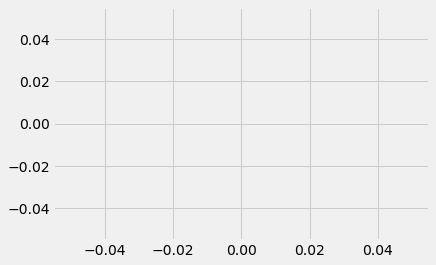

In [34]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import style
style.use('fivethirtyeight')

from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
time_step_to_test_t1 = 0    # [batch_set, prediction frames(t1->tx)(6), batch_size, features(48)]
time_step_to_test_t5 = 4
time_step_to_test_t9 = 9
predicted_data_t1 = []
predicted_data_t5 = []
predicted_data_t9 = []
groundtruth_data = []
time_stepsto_plot = []
test_t = []
test_d1 = []
test_d2 = []
test_a = []
experiment_to_test = len(p) - 4  # experiment 106 as its the last one
for batchset in range(len(tactile_predictions)):
    for batch in range(len(tactile_predictions[batchset][time_step_to_test_t9])):
        experiment = experiment_time_steps[batchset][0][batch][0].numpy()
        time_step = experiment_time_steps[batchset][1][batch][0].numpy()
        if experiment == experiment_to_test:
            predicted_data_t1.append(tactile_predictions[batchset][time_step_to_test_t1][batch])
            predicted_data_t5.append(tactile_predictions[batchset][time_step_to_test_t5][batch])
            predicted_data_t9.append(tactile_predictions[batchset][time_step_to_test_t9][batch])
            groundtruth_data.append(tactile_groundtruth[batchset][0][batch])
            time_stepsto_plot.append(time_step.item())
# [108, data_sample_2021-03-26-09-45-38']
# [128, data_sample_2021-03-26-09-48-32']
# [193, data_sample_2021-03-26-09-40-56']
# order  = 108 128 193 106]
print(time_stepsto_plot)
index = 0
plot_range_start = 0 # 0
plot_range_stop  = len(time_stepsto_plot) # len(time_stepsto_plot)
experiment_to_test = 108
titles = ["sheerx", "sheery", "normal"]
for j in range(3):
    for i in range(16):
        groundtruth_taxle = []
        predicted_taxel = []
        predicted_taxel_t1 = []
        predicted_taxel_t5 = []
        predicted_taxel_t9 = []
        # good = 140, 145 (lifting up the )
        for k in range(plot_range_start, plot_range_stop):# len(predicted_data_t1)):#310, 325):#len(predicted_data_t1)):  # add in length of context data
            predicted_taxel_t1.append(predicted_data_t1[k][index].cpu().detach().numpy())
            predicted_taxel_t5.append(predicted_data_t5[k][index].cpu().detach().numpy())
            predicted_taxel_t9.append(predicted_data_t9[k][index].cpu().detach().numpy())
            groundtruth_taxle.append(groundtruth_data[k][index].cpu().detach().numpy())

        index += 1

        
        
        
        fig, ax1 = plt.subplots()
        ax1.set_xlabel('time step')
        ax1.set_ylabel('tactile reading')
        
        def animate(time_step):
            ax1.clear()
            ax1.plot([value for value in time_stepsto_plot[plot_range_start:time_step]], [i for i in predicted_taxel_t1[:time_step]], alpha=0.5, c="b", label="t1")
            ax1.plot([value for value in time_stepsto_plot[plot_range_start:time_step]], [i for i in predicted_taxel_t5[:time_step]], alpha=0.5, c="k", label="t5")
            ax1.plot([value for value in time_stepsto_plot[plot_range_start:time_step]], [i for i in predicted_taxel_t9[:time_step]], alpha=0.5, c="g", label="t10")
            ax1.plot([value for value in time_stepsto_plot[plot_range_start:time_step]], groundtruth_taxle, alpha=0.5, c="r", label="gt")

        ani = animation.FuncAnimation(fig, animate, interval=20.8)
        ani.save('animation_test.gif', writer='imagemagick', fps=48)
        plt.show()

        
#         ax1.tick_params(axis='y')
#         fig.tight_layout()  # otherwise the right y-label is slightly clipped
#         fig.subplots_adjust(top=0.90)
#         ax1.legend(loc="upper right")
        
#         ax1.xaxis.set_minor_locator(AutoMinorLocator())
#         ax1.tick_params(which='minor', length=1, color='k')
#         ax1.grid(which='minor')
#         ax1.grid(which='major')
        
#         plt.title("Inline Simple_LSTM tactile " + str(index) + "_" + titles[j])
#         plt.savefig(model_path + '/' + str(experiment_to_test) + '/10step_prediction/timestep_' + str(plot_range_start) + "_" + str(plot_range_stop) + '_tactile_' + str(index) + '.png', dpi=300)
#         plt.show()
        break
    break

In [ ]:
# TEST THE MODEL ON KENNY'S DATASET
to_test = "/home/user/Robotics/Data_sets/slip_detection/will_dataset/data_collection_200/data_collection_001/data_sample_2021-03-26-09-48-32"

# -*- coding: utf-8 -*-
### RUN IN PYTHON 3
import os
import cv2
import csv
import glob
import click
import logging
import numpy as np
import pandas as pd

from PIL import Image 
from tqdm import tqdm
from dotenv import find_dotenv, load_dotenv
from sklearn import preprocessing
from sklearn.decomposition import PCA

from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.spatial.transform import Rotation as R
from scipy.ndimage.interpolation import map_coordinates

data_dir = '/home/user/Robotics/Data_sets/slip_detection/will_dataset/data_collection_200/data_collection_001/'
out_dir = '/home/user/Robotics/Data_sets/slip_detection/manual_slip_detection/'
SAVE_IMAGES= True
sequence_length = 20 # 20 for 10 step prediction or even 58 frames
image_height, image_width = 32, 32
save_deriv1 = False
save_deriv2 = False

## Load the data:
files = glob.glob(data_dir + '/*')
path_file = []
index_to_save = 0

xela_sensor1_data_x_final, xela_sensor1_data_y_final, xela_sensor1_data_z_final = [], [], []
xela_sensor1_data_x_final_1stderiv = []
xela_sensor1_data_y_final_1stderiv = []
xela_sensor1_data_z_final_1stderiv = []
xela_sensor1_data_x_final_2stderiv = []
xela_sensor1_data_y_final_2stderiv = []
xela_sensor1_data_z_final_2stderiv = []


ee_positions_final = []
ee_position_x_final = []
ee_position_y_final = []
ee_position_z_final = []
ee_orientation_quat_x_final = []
ee_orientation_quat_y_final = []
ee_orientation_quat_z_final = []
ee_orientation_quat_w_final = []
ee_orientation_x_final = []
ee_orientation_y_final = []
ee_orientation_z_final = []

exp_break_points = []
exp_break_point = 0
cut = 0
for experiment_number in tqdm(range(len(files))):
    if files[experiment_number] == to_test:
        to_test_index = experiment_number
    meta_data = np.asarray(pd.read_csv(files[experiment_number] + '/meta_data.csv', header=None))
    robot_state  = np.asarray(pd.read_csv(files[experiment_number] + '/robot_state.csv', header=None))
    proximity    = np.asarray(pd.read_csv(files[experiment_number] + '/proximity.csv', header=None))
    xela_sensor1 = np.asarray(pd.read_csv(files[experiment_number] + '/xela_sensor1.csv', header=None))
    xela_sensor2 = np.asarray(pd.read_csv(files[experiment_number] + '/xela_sensor2.csv', header=None))

    ee_positions = []
    ee_position_x, ee_position_y, ee_position_z = [], [], []
    ee_orientation_x, ee_orientation_y, ee_orientation_z = [], [], []
    ee_orientation_quat_x, ee_orientation_quat_y, ee_orientation_quat_z, ee_orientation_quat_w = [], [], [], []

    xela_sensor1_data_x, xela_sensor1_data_y, xela_sensor1_data_z = [], [], []
    xela_sensor2_data_x, xela_sensor2_data_y, xela_sensor2_data_z = [], [], []
    xela_sensor1_data_x_mean, xela_sensor1_data_y_mean, xela_sensor1_data_z_mean = [], [], []
    xela_sensor2_data_x_mean, xela_sensor2_data_y_mean, xela_sensor2_data_z_mean = [], [], []

    ####################################### Robot Data ###########################################
    for state in robot_state[1:]:
        ee_positions.append([float(item) for item in robot_state[1][-7:-4]])
        ee_position_x.append(state[-7])
        ee_position_y.append(state[-6])
        ee_position_z.append(state[-5])
        # quat
        ee_orientation_quat_x.append(state[-4])
        ee_orientation_quat_y.append(state[-3])
        ee_orientation_quat_z.append(state[-2])
        ee_orientation_quat_w.append(state[-1])
        # euler
        ee_orientation = R.from_quat([state[-4], state[-3], state[-2], state[-1]]).as_euler('zyx', degrees=True)
        ee_orientation_x.append(ee_orientation[0])
        ee_orientation_y.append(ee_orientation[1])
        ee_orientation_z.append(ee_orientation[2])
        exp_break_point += 1

    # fix the euler angles:
    for i in range(len(ee_orientation_z)):
        if ee_orientation_z[i] < 0:
            ee_orientation_z[i] += 360

    ####################################### Xela Data ###########################################
    for sample1, sample2 in zip(xela_sensor1[1:], xela_sensor2[1:]):
        sample1_data_x, sample1_data_y, sample1_data_z = [], [], []
        sample2_data_x, sample2_data_y, sample2_data_z = [], [], []
        for i in range(0, len(xela_sensor1[0]), 3):
            sample1_data_x.append(float(sample1[i]))
            sample1_data_y.append(float(sample1[i+1]))
            sample1_data_z.append(float(sample1[i+2]))
        xela_sensor1_data_x.append(sample1_data_x)
        xela_sensor1_data_y.append(sample1_data_y)
        xela_sensor1_data_z.append(sample1_data_z)

    # mean starting values:
    xela_sensor1_average_starting_value_x = int(sum(xela_sensor1_data_x[0]) / len(xela_sensor1_data_x[0]))
    xela_sensor1_average_starting_value_y = int(sum(xela_sensor1_data_y[0]) / len(xela_sensor1_data_y[0]))
    xela_sensor1_average_starting_value_z = int(sum(xela_sensor1_data_z[0]) / len(xela_sensor1_data_z[0]))
    xela_sensor1_offset_x = [xela_sensor1_average_starting_value_x - tactile_starting_value for tactile_starting_value in xela_sensor1_data_x[0]]
    xela_sensor1_offset_y = [xela_sensor1_average_starting_value_y - tactile_starting_value for tactile_starting_value in xela_sensor1_data_y[0]]
    xela_sensor1_offset_z = [xela_sensor1_average_starting_value_z - tactile_starting_value for tactile_starting_value in xela_sensor1_data_z[0]]

    for time_step in range(len(xela_sensor1_data_x)):
        xela_sensor1_sample_x_test = [offset+real_value for offset, real_value in zip(xela_sensor1_offset_x, xela_sensor1_data_x[time_step])]
        xela_sensor1_sample_y_test = [offset+real_value for offset, real_value in zip(xela_sensor1_offset_y, xela_sensor1_data_y[time_step])]
        xela_sensor1_sample_z_test = [offset+real_value for offset, real_value in zip(xela_sensor1_offset_z, xela_sensor1_data_z[time_step])]
        for i in range(np.asarray(xela_sensor1_data_x).shape[1]):
            xela_sensor1_data_x[time_step][i] = xela_sensor1_sample_x_test[i]
            xela_sensor1_data_y[time_step][i] = xela_sensor1_sample_y_test[i] 
            xela_sensor1_data_z[time_step][i] = xela_sensor1_sample_z_test[i]

    # calculate the derivatives
    if save_deriv1 == True:
        cut = 1
        xela_deriv1_x = np.diff(np.array(xela_sensor1_data_x), axis=0).tolist()
        xela_deriv1_y = np.diff(np.array(xela_sensor1_data_y), axis=0).tolist()
        xela_deriv1_z = np.diff(np.array(xela_sensor1_data_z), axis=0).tolist()
        # store the data:
        xela_sensor1_data_x_final_1stderiv += xela_deriv1_x 
        xela_sensor1_data_y_final_1stderiv += xela_deriv1_y 
        xela_sensor1_data_z_final_1stderiv += xela_deriv1_z 

    if save_deriv2 == True:
        cut = 2
        xela1_deriv2_x = np.diff(np.array(xela_sensor1_data_x), axis=0, n=2).tolist()
        xela1_deriv2_y = np.diff(np.array(xela_sensor1_data_y), axis=0, n=2).tolist()
        xela1_deriv2_z = np.diff(np.array(xela_sensor1_data_z), axis=0, n=2).tolist()
        # store the data:
        xela_sensor1_data_x_final_2stderiv += xela1_deriv2_x 
        xela_sensor1_data_y_final_2stderiv += xela1_deriv2_y 
        xela_sensor1_data_z_final_2stderiv += xela1_deriv2_z        

    xela_sensor1_data_x_final += xela_sensor1_data_x[cut:]
    xela_sensor1_data_y_final += xela_sensor1_data_y[cut:]
    xela_sensor1_data_z_final += xela_sensor1_data_z[cut:]
    ee_positions_final += ee_positions[cut:]
    ee_position_x_final += ee_position_x[cut:]
    ee_position_y_final += ee_position_y[cut:]
    ee_position_z_final += ee_position_z[cut:]
    ee_orientation_quat_x_final += ee_orientation_quat_x[cut:]
    ee_orientation_quat_y_final += ee_orientation_quat_y[cut:]
    ee_orientation_quat_z_final += ee_orientation_quat_z[cut:]
    ee_orientation_quat_w_final += ee_orientation_quat_w[cut:]
    ee_orientation_x_final += ee_orientation_x[cut:]
    ee_orientation_y_final += ee_orientation_y[cut:]
    ee_orientation_z_final += ee_orientation_z[cut:]

    exp_break_points.append(exp_break_point - cut)

        
        
        
xela_sensor1_data_x_final = np.asarray(xela_sensor1_data_x_final)
xela_sensor1_data_y_final = np.asarray(xela_sensor1_data_y_final)
xela_sensor1_data_z_final = np.asarray(xela_sensor1_data_z_final)

scale_together = False
if scale_together == True:
    xela_sensor1_data = np.concatenate((xela_sensor1_data_x_final, xela_sensor1_data_y_final, xela_sensor1_data_z_final), axis=1)
    scaler_full = preprocessing.StandardScaler().fit(xela_sensor1_data)
    xela_sensor1_data_scaled = scaler_full.transform(xela_sensor1_data)
    min_max_scaler_full_data = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(xela_sensor1_data_scaled)
    xela_sensor1_data_scaled_minmax = min_max_scaler_full_data.transform(xela_sensor1_data_scaled)

elif scale_together == False:
    scaler_tx = preprocessing.StandardScaler().fit(xela_sensor1_data_x_final)
    scaler_ty = preprocessing.StandardScaler().fit(xela_sensor1_data_y_final)
    scaler_tz = preprocessing.StandardScaler().fit(xela_sensor1_data_z_final)
    xelax_sensor1_data_scaled = scaler_tx.transform(xela_sensor1_data_x_final)
    xelay_sensor1_data_scaled = scaler_ty.transform(xela_sensor1_data_y_final)
    xelaz_sensor1_data_scaled = scaler_tz.transform(xela_sensor1_data_z_final)
    xela_sensor1_data_scaled = np.concatenate((xelax_sensor1_data_scaled,
                                               xelay_sensor1_data_scaled,
                                               xelaz_sensor1_data_scaled), axis=1)
    
    min_max_scalerx_full_data = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(xelax_sensor1_data_scaled)
    min_max_scalery_full_data = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(xelay_sensor1_data_scaled)
    min_max_scalerz_full_data = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(xelaz_sensor1_data_scaled)    
    xelax_sensor1_data_scaled_minmax = min_max_scalerx_full_data.transform(xelax_sensor1_data_scaled)
    xelay_sensor1_data_scaled_minmax = min_max_scalery_full_data.transform(xelay_sensor1_data_scaled)
    xelaz_sensor1_data_scaled_minmax = min_max_scalerz_full_data.transform(xelaz_sensor1_data_scaled)

    xela_sensor1_data_scaled_minmax = np.concatenate((xelax_sensor1_data_scaled_minmax,
                                        xelay_sensor1_data_scaled_minmax,
                                        xelaz_sensor1_data_scaled_minmax), axis=1)
    
if save_deriv1 == True:
    scaler_td1x = preprocessing.StandardScaler().fit(xela_sensor1_data_x_final_1stderiv)
    scaler_td1y = preprocessing.StandardScaler().fit(xela_sensor1_data_y_final_1stderiv)
    scaler_td1z = preprocessing.StandardScaler().fit(xela_sensor1_data_z_final_1stderiv)
    xelax_sensor1d1_data_scaled = scaler_td1x.transform(xela_sensor1_data_x_final_1stderiv)
    xelay_sensor1d1_data_scaled = scaler_td1y.transform(xela_sensor1_data_y_final_1stderiv)
    xelaz_sensor1d1_data_scaled = scaler_td1z.transform(xela_sensor1_data_z_final_1stderiv)
    xelad1_sensor1_data_scaled = np.concatenate((xelax_sensor1d1_data_scaled,
                                               xelay_sensor1d1_data_scaled,
                                               xelaz_sensor1d1_data_scaled), axis=1)
    
    min_max_scalerd1x_full_data = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(xelax_sensor1d1_data_scaled)
    min_max_scalerd1y_full_data = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(xelay_sensor1d1_data_scaled)
    min_max_scalerd1z_full_data = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(xelaz_sensor1d1_data_scaled)    
    xelad1x_sensor1_data_scaled_minmax = min_max_scalerd1x_full_data.transform(xelax_sensor1d1_data_scaled)
    xelad1y_sensor1_data_scaled_minmax = min_max_scalerd1y_full_data.transform(xelay_sensor1d1_data_scaled)
    xelad1z_sensor1_data_scaled_minmax = min_max_scalerd1z_full_data.transform(xelaz_sensor1d1_data_scaled)

    xelad1_sensor1_data_scaled_minmax = np.concatenate((xelad1x_sensor1_data_scaled_minmax,
                                        xelad1y_sensor1_data_scaled_minmax,
                                        xelad1z_sensor1_data_scaled_minmax), axis=1)

if save_deriv2 == True:
    scaler_td2x = preprocessing.StandardScaler().fit(xela_sensor1_data_x_final_2stderiv)
    scaler_td2y = preprocessing.StandardScaler().fit(xela_sensor1_data_y_final_2stderiv)
    scaler_td2z = preprocessing.StandardScaler().fit(xela_sensor1_data_z_final_2stderiv)
    xelax_sensor1d2_data_scaled = scaler_td2x.transform(xela_sensor1_data_x_final_2stderiv)
    xelay_sensor1d2_data_scaled = scaler_td2y.transform(xela_sensor1_data_y_final_2stderiv)
    xelaz_sensor1d2_data_scaled = scaler_td2z.transform(xela_sensor1_data_z_final_2stderiv)
    xelad2_sensor1_data_scaled = np.concatenate((xelax_sensor1d2_data_scaled,
                                               xelay_sensor1d2_data_scaled,
                                               xelaz_sensor1d2_data_scaled), axis=1)
    
    min_max_scalerd2x_full_data = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(xelax_sensor1d2_data_scaled)
    min_max_scalerd2y_full_data = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(xelay_sensor1d2_data_scaled)
    min_max_scalerd2z_full_data = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(xelaz_sensor1d2_data_scaled)    
    xelad2x_sensor1_data_scaled_minmax = min_max_scalerd2x_full_data.transform(xelax_sensor1d2_data_scaled)
    xelad2y_sensor1_data_scaled_minmax = min_max_scalerd2y_full_data.transform(xelay_sensor1d2_data_scaled)
    xelad2z_sensor1_data_scaled_minmax = min_max_scalerd2z_full_data.transform(xelaz_sensor1d2_data_scaled)

    xelad2_sensor1_data_scaled_minmax = np.concatenate((xelad2x_sensor1_data_scaled_minmax,
                                        xelad2y_sensor1_data_scaled_minmax,
                                        xelad2z_sensor1_data_scaled_minmax), axis=1)

    
# -*- coding: utf-8 -*-
import csv
import tqdm
import copy
import click
import logging
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset

from string import digits

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F

seed = 42
epochs = 100
batch_size = 32
learning_rate = 1e-3
context_frames = 10
# sequence_length = 10 # 20 for 10 step prediction
lookback = sequence_length

valid_train_split = 0.85  # precentage of train data from total
test_train_split = 0.95  # precentage of train data from total

torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")#  use gpu if available
################################# CHANGE THIS!!!!  #################################
model_path = "/home/user/Robotics/slip_detection_model/slip_detection_model/manual_data_models/models/simple_model_004/"
################################# CHANGE THIS!!!!  #################################

# scale between 0 and 1:
ee_position_x_final = np.array(ee_position_x_final) 
ee_position_y_final = np.array(ee_position_y_final) 
ee_position_z_final = np.array(ee_position_z_final) 
ee_orientation_quat_x_final = np.array(ee_orientation_quat_x_final).reshape(-1, 1)
ee_orientation_quat_y_final = np.array(ee_orientation_quat_y_final).reshape(-1, 1)
ee_orientation_quat_z_final = np.array(ee_orientation_quat_z_final).reshape(-1, 1)
ee_orientation_quat_w_final = np.array(ee_orientation_quat_w_final).reshape(-1, 1)
ee_orientation_x_final = np.array(ee_orientation_x_final)
ee_orientation_y_final = np.array(ee_orientation_y_final)
ee_orientation_z_final = np.array(ee_orientation_z_final)
# xela_sensor1_principle_components = np.array(xela_sensor1_principle_components) 
xela_sensor1_principle_components =  np.array(xela_sensor1_data_scaled)
if save_deriv1 == True:
    xelad1_sensor1_data_scaled_minmax = np.array(xelad1_sensor1_data_scaled_minmax)
if save_deriv2 == True:
    xelad2_sensor1_data_scaled_minmax = np.array(xelad2_sensor1_data_scaled_minmax)

min_max_scaler_ee_position_x_final = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(ee_position_x_final.reshape(-1, 1))
ee_position_x_final_scaled = min_max_scaler_ee_position_x_final.transform(ee_position_x_final.reshape(-1, 1))

min_max_scaler_ee_position_y_final = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(ee_position_y_final.reshape(-1, 1))
ee_position_y_final_scaled = min_max_scaler_ee_position_y_final.transform(ee_position_y_final.reshape(-1, 1))

min_max_scaler_ee_position_z_final = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(ee_position_z_final.reshape(-1, 1))
ee_position_z_final_scaled = min_max_scaler_ee_position_z_final.transform(ee_position_z_final.reshape(-1, 1))

min_max_scaler_ee_orientation_quat_x_final = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(ee_orientation_quat_x_final)
ee_orientation_quat_x_final_scaled = min_max_scaler_ee_orientation_quat_x_final.transform(ee_orientation_quat_x_final)

min_max_scaler_ee_orientation_quat_y_final = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(ee_orientation_quat_y_final)
ee_orientation_quat_y_final_scaled = min_max_scaler_ee_orientation_quat_y_final.transform(ee_orientation_quat_y_final)

min_max_scaler_ee_orientation_quat_z_final = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(ee_orientation_quat_z_final)
ee_orientation_quat_z_final_scaled = min_max_scaler_ee_orientation_quat_z_final.transform(ee_orientation_quat_z_final)

min_max_scaler_ee_orientation_quat_w_final = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(ee_orientation_quat_w_final)
ee_orientation_quat_w_final_scaled = min_max_scaler_ee_orientation_quat_w_final.transform(ee_orientation_quat_w_final)

min_max_scaler_ee_orientation_x_final = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(ee_orientation_x_final.reshape(-1, 1))
ee_orientation_x_final_scaled = min_max_scaler_ee_orientation_x_final.transform(ee_orientation_x_final.reshape(-1, 1))

min_max_scaler_ee_orientation_y_final = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(ee_orientation_y_final.reshape(-1, 1))
ee_orientation_y_final_scaled = min_max_scaler_ee_orientation_y_final.transform(ee_orientation_y_final.reshape(-1, 1))

min_max_scaler_ee_orientation_z_final = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(ee_orientation_z_final.reshape(-1, 1))
ee_orientation_z_final_scaled = min_max_scaler_ee_orientation_z_final.transform(ee_orientation_z_final.reshape(-1, 1))

if scale_together == True:
    min_max_scaler_xela_sensor1_principle_components = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(xela_sensor1_principle_components)
    xela_sensor1_principle_components_scaled = min_max_scaler_xela_sensor1_principle_components.transform(xela_sensor1_principle_components)
else:
    xela_sensor1_principle_components_scaled = xela_sensor1_data_scaled_minmax

if save_deriv1 == True:
    xelad1_sensor1_principle_components_scaled = xelad1_sensor1_data_scaled_minmax
if save_deriv2 == True:
    xelad2_sensor1_principle_components_scaled = xelad2_sensor1_data_scaled_minmax

# Convert data back into split experiments to create the sequences:
ee_position_x_final_split = np.asarray(np.split(ee_position_x_final_scaled, exp_break_points)[0:-1])
ee_position_y_final_split = np.asarray(np.split(ee_position_y_final_scaled, exp_break_points)[0:-1])
ee_position_z_final_split = np.asarray(np.split(ee_position_z_final_scaled, exp_break_points)[0:-1])
ee_orientation_quat_x_final_split = np.asarray(np.split(ee_orientation_quat_x_final_scaled, exp_break_points)[0:-1])
ee_orientation_quat_y_final_split = np.asarray(np.split(ee_orientation_quat_y_final_scaled, exp_break_points)[0:-1])
ee_orientation_quat_z_final_split = np.asarray(np.split(ee_orientation_quat_z_final_scaled, exp_break_points)[0:-1])
ee_orientation_quat_w_final_split = np.asarray(np.split(ee_orientation_quat_w_final_scaled, exp_break_points)[0:-1])
ee_orientation_x_final_split = np.asarray(np.split(ee_orientation_x_final_scaled, exp_break_points)[0:-1])
ee_orientation_y_final_split = np.asarray(np.split(ee_orientation_y_final_scaled, exp_break_points)[0:-1])
ee_orientation_z_final_split = np.asarray(np.split(ee_orientation_z_final_scaled, exp_break_points)[0:-1])
xela_sensor1_principle_components_split = np.asarray(np.split(xela_sensor1_principle_components_scaled, exp_break_points)[0:-1])
if save_deriv1 == True:
    xela_sensor1_data_1stderiv_scaled_split = np.asarray(np.split(xelad1_sensor1_principle_components_scaled, exp_break_points)[0:-1])
if save_deriv2 == True:
    xela_sensor1_data_2stderiv_scaled_split = np.asarray(np.split(xelad2_sensor1_principle_components_scaled, exp_break_points)[0:-1])

In [ ]:
# p = np.random.permutation(len(ee_position_x_final_split))
# p = np.delete(p, np.where(p==to_test_index))  # make 106 always in the test set (for comparing graphs)
# p = np.append(p, [to_test_index])
# p = np.array([to_test_index])
p = np.load("/home/user/Robotics/slip_detection_model/slip_detection_model/manual_data_models/models/simple_model_004/shuffle_order.npy", )
print("shuffle order: ", p)
for index, i in enumerate(p):
    if i == 128:
        print(index)
# tester = ee_position_x_final_split[p]
# print(tester.shape)
# ee_position_x_final_split = ee_position_x_final_split[p]
# ee_position_y_final_split = ee_position_y_final_split[p]
# ee_position_z_final_split = ee_position_z_final_split[p]
# ee_orientation_quat_x_final_split = ee_orientation_quat_x_final_split[p]
# ee_orientation_quat_y_final_split = ee_orientation_quat_y_final_split[p]
# ee_orientation_quat_z_final_split = ee_orientation_quat_z_final_split[p]
# ee_orientation_quat_w_final_split = ee_orientation_quat_w_final_split[p]
# ee_orientation_x_final_split = ee_orientation_x_final_split[p]
# ee_orientation_y_final_split = ee_orientation_y_final_split[p]
# ee_orientation_z_final_split = ee_orientation_z_final_split[p]

In [ ]:
# Shuffle data:
# p = np.random.permutation(len(ee_position_x_final_split))
# p = np.delete(p, np.where(p==to_test_index))  # make 106 always in the test set (for comparing graphs)
# p = np.append(p, [to_test_index])
# p = np.load("/home/user/Robotics/slip_detection_model/slip_detection_model/manual_data_models/models/simple_model_004/shuffle_order.npy", )
p = np.array([to_test_index])
print("shuffle order: ", p)
ee_position_x_final_split = ee_position_x_final_split[p]
ee_position_y_final_split = ee_position_y_final_split[p]
ee_position_z_final_split = ee_position_z_final_split[p]
ee_orientation_quat_x_final_split = ee_orientation_quat_x_final_split[p]
ee_orientation_quat_y_final_split = ee_orientation_quat_y_final_split[p]
ee_orientation_quat_z_final_split = ee_orientation_quat_z_final_split[p]
ee_orientation_quat_w_final_split = ee_orientation_quat_w_final_split[p]
ee_orientation_x_final_split = ee_orientation_x_final_split[p]
ee_orientation_y_final_split = ee_orientation_y_final_split[p]
ee_orientation_z_final_split = ee_orientation_z_final_split[p]
xela_sensor1_principle_components_split = xela_sensor1_principle_components_split[p]
if save_deriv1 == True:
    xela_sensor1_data_1stderiv_scaled_split = xela_sensor1_data_1stderiv_scaled_split[p]
if save_deriv2 == True:
    xela_sensor1_data_2stderiv_scaled_split = xela_sensor1_data_2stderiv_scaled_split[p]

ee_position_x_final = []
ee_position_y_final = []
ee_position_z_final = []
ee_orientation_quat_x_final = []
ee_orientation_quat_y_final = []
ee_orientation_quat_z_final = []
ee_orientation_quat_w_final = []
ee_orientation_x_final = []
ee_orientation_y_final = []
ee_orientation_z_final = []
xela_sensor1_principle_components = []
ee_position_x_final_scaled = []
ee_position_y_final_scaled = []
ee_position_z_final_scaled = []
ee_orientation_quat_x_final_scaled = []
ee_orientation_quat_y_final_scaled = []
ee_orientation_quat_z_final_scaled = []
ee_orientation_quat_w_final_scaled = []
ee_orientation_x_final_scaled = []
ee_orientation_y_final_scaled = []
ee_orientation_z_final_scaled = []
xela_sensor1_data_x_final = []
xela_sensor1_data_y_final = []
xela_sensor1_data_z_final = []
ee_positions_final = []
ee_position_x_final = []
ee_position_y_final = []
ee_position_z_final = []
ee_orientation_quat_x_final = []
ee_orientation_quat_y_final = []
ee_orientation_quat_z_final = []
ee_orientation_quat_w_final = []
ee_orientation_x_final = []
ee_orientation_y_final = []
ee_orientation_z_final = []

xela_sensor1_data_x_final = []
xela_sensor1_data_y_final = []
xela_sensor1_data_z_final = []
xelax_sensor1_data_scaled_minmax = []
xelay_sensor1_data_scaled_minmax = []
xelaz_sensor1_data_scaled_minmax = []
xela_sensor1_data_scaled_minmax = []


# convert to sequences:
robot_data_euler_sequence, robot_data_quat_sequence, xela_1_sequence_data, experiment_data_sequence, time_step_data_sequence = [], [], [], [], []
xela1_1stderiv_sequence = []
xela1_2stderiv_sequence = []
for experiment in range(len(ee_position_x_final_split)):
    for sample in range(0, len(ee_position_x_final_split[experiment]) - sequence_length):
        robot_data_euler_sample, robot_data_quat_sample, xela_1_sequ_sample, experiment_data_sample, time_step_data_sample = [], [], [], [], []
        xela_sensor1_1stderiv = []
        xela_sensor1_2stderiv = []
        for t in range(0, sequence_length):
            robot_data_euler_sample.append([ee_position_x_final_split[experiment][sample+t], ee_position_y_final_split[experiment][sample+t], ee_position_z_final_split[experiment][sample+t], ee_orientation_x_final_split[experiment][sample+t], ee_orientation_y_final_split[experiment][sample+t], ee_orientation_z_final_split[experiment][sample+t]])
            robot_data_quat_sample.append([ee_position_x_final_split[experiment][sample+t], ee_position_y_final_split[experiment][sample+t], ee_position_z_final_split[experiment][sample+t], ee_orientation_quat_x_final_split[experiment][sample+t][0], ee_orientation_quat_y_final_split[experiment][sample+t][0], ee_orientation_quat_z_final_split[experiment][sample+t][0], ee_orientation_quat_w_final_split[experiment][sample+t][0]])
            xela_1_sequ_sample.append(xela_sensor1_principle_components_split[experiment][sample+t])
            if save_deriv1 == True:
                xela_sensor1_1stderiv.append(xela_sensor1_data_1stderiv_scaled_split[experiment][sample+t])
            if save_deriv2 == True:
                xela_sensor1_2stderiv.append(xela_sensor1_data_2stderiv_scaled_split[experiment][sample+t])
            experiment_data_sample.append(experiment)
            time_step_data_sample.append(sample+t)
        robot_data_euler_sequence.append(robot_data_euler_sample)
        robot_data_quat_sequence.append(robot_data_quat_sample)
        xela_1_sequence_data.append(xela_1_sequ_sample)
        xela1_1stderiv_sequence.append(xela_sensor1_1stderiv)
        xela1_2stderiv_sequence.append(xela_sensor1_2stderiv)
        experiment_data_sequence.append(experiment_data_sample)
        time_step_data_sequence.append(time_step_data_sample)

class BatchGenerator:
    def __init__(self):
        pass

    def load_full_data(self):
        dataset_train = FullDataSet(type_="train")
        transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
        train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=False)
        return train_loader

class FullDataSet():
    def __init__(self, type_="train"):
        if type_ == "train":
            self.samples = [0, len(robot_data_euler_sequence)]

    def __len__(self):
        return self.samples[1] - self.samples[0]

    def __getitem__(self,idx):
        robot_euler = robot_data_euler_sequence[self.samples[0] + idx]
        xela1 = xela_1_sequence_data[self.samples[0] + idx]
        experiment = experiment_data_sequence[self.samples[0] + idx]
        time_step  = time_step_data_sequence[self.samples[0] + idx]
        return([np.array(robot_euler).astype(np.float32),
                np.array(xela1).astype(np.float32),
                np.array(experiment),
                np.array(time_step)])

# single LSTM attempt
class FullModel(nn.Module):
    def __init__(self):
        super(FullModel, self).__init__()
        self.lstm1 = nn.LSTM(48 + 48, 200).to(device)  # tactile
        self.lstm2 = nn.LSTM(200, 200).to(device)  # tactile
        self.fc1 = nn.Linear(200 + 48, 200).to(device)  # tactile + pos_vel
        self.fc2 = nn.Linear(200, 48).to(device)  # tactile + pos_vel
        self.tan_activation = nn.Tanh().to(device)

    def forward(self, tactiles, actions, tac_deriv1, tac_deriv2):
        state = actions[0]
        state.to(device)
        batch_size__ = tactiles.shape[1]
        outputs = []
        hidden1 = (torch.zeros(1,batch_size__,200, device=torch.device('cuda')), torch.zeros(1,batch_size__,200, device=torch.device('cuda')))
        hidden2 = (torch.zeros(1,batch_size__,200, device=torch.device('cuda')), torch.zeros(1,batch_size__,200, device=torch.device('cuda')))

        for index, (sample_tactile, sample_action, sample_tactilederiv1, sample_tactilederiv1) in enumerate(zip(tactiles.squeeze(), actions.squeeze(), tac_deriv1.squeeze(), tac_deriv2.squeeze()), ):
            # 2. Run through lstm:
            if index > context_frames-1:
                out4 = out4 .squeeze()
                tiled_action_and_state = torch.cat((sample_action, state, sample_action, state,
                                                   sample_action, state, sample_action, state), 1)                
                action_and_tactile = torch.cat((out4, tiled_action_and_state), 1)
                out1, hidden1 = self.lstm1(action_and_tactile.unsqueeze(0), hidden1)
                out2, hidden2 = self.lstm2(out1, hidden2)
                lstm_and_prev_tactile = torch.cat((out2.squeeze(), out4), 1)
                out3 = self.tan_activation(self.fc1(lstm_and_prev_tactile))
                out4 = self.tan_activation(self.fc2(out3))
                outputs.append(out4.squeeze())
            else:
                tiled_action_and_state = torch.cat((sample_action, state, sample_action, state,
                                                   sample_action, state, sample_action, state), 1)                
                action_and_tactile = torch.cat((sample_tactile, tiled_action_and_state), 1)                
                out1, hidden1 = self.lstm1(action_and_tactile.unsqueeze(0), hidden1)
                out2, hidden2 = self.lstm2(out1, hidden2)
                lstm_and_prev_tactile = torch.cat((out2.squeeze(), sample_tactile), 1)
                out3 = self.tan_activation(self.fc1(lstm_and_prev_tactile))
                out4 = self.tan_activation(self.fc2(out3))

        return torch.stack(outputs)

    
print("Done")
    

In [ ]:
# test model on the full test sample:
BG = BatchGenerator()
model = torch.load(model_path + "trained_model")
model.eval()

criterion1 = nn.L1Loss()
criterion2 = nn.MSELoss()
BG = BatchGenerator()
train_full_loader = BG.load_full_data()

test_lossesMAE_t1 = 0.0
test_lossesMAE_t5 = 0.0
test_lossesMAE_t10 = 0.0
test_lossesMAE_scaled = 0.0
test_lossesMAE_t15 = 0.0
test_lossesMAE_t20 = 0.0
test_lossesMAE_t25 = 0.0
test_lossesMAE_t35 = 0.0
test_lossesMAE_t40 = 0.0
test_lossesMAE_t48 = 0.0

tactile_gt_test = []
tactile_gt_d1_test = []
tactile_gt_d2_test = []
action_test = []

tactile_predictions = []
tactile_groundtruth = []
experiment_time_steps = []
test_lossesMAE = 0.0
test_lossesMSE = 0.0
with torch.no_grad():
    for index__, batch_features in enumerate(train_full_loader):
        print(index__)
        # 2. Reshape data and send to device:
        action = batch_features[0].squeeze(-1).permute(1,0,2).to(device)
        tactile = batch_features[1].permute(1,0,2).to(device)
        tactilederiv1 = batch_features[2].unsqueeze(2).permute(1,0,2).to(device)
        tactilederiv2 = batch_features[3].unsqueeze(2).permute(1,0,2).to(device)
        tp = model.forward(tactiles=tactile, actions=action, tac_deriv1=tactilederiv1, tac_deriv2=tactilederiv2) # Step 3. Run our forward pass.
        experiment_time_steps.append([batch_features[-2], batch_features[-1]])
        tp = tp[:,:,:48]
        ############ RESCALE THE DATA HERE ################
        tp_back_scaled = []
        tg_back_scaled = []
        for i in range(len(tp)+1):
            if scale_together == False:
                if i is not 0:
                    # tp:
                    (tpx, tpy, tpz) = np.split(tp[i-1].cpu().detach(), 3, axis=1)
                    xela_x_inverse_minmax = min_max_scalerx_full_data.inverse_transform(tpx)
                    xela_y_inverse_minmax = min_max_scalery_full_data.inverse_transform(tpy)
                    xela_z_inverse_minmax = min_max_scalerz_full_data.inverse_transform(tpz)
                    xela_x_inverse_full = scaler_tx.inverse_transform(xela_x_inverse_minmax)
                    xela_y_inverse_full = scaler_ty.inverse_transform(xela_y_inverse_minmax)
                    xela_z_inverse_full = scaler_tz.inverse_transform(xela_z_inverse_minmax)
                    tp_back_scaled.append(np.concatenate((xela_x_inverse_full,
                                                         xela_y_inverse_full,
                                                         xela_z_inverse_full), axis=1))
                # tg:
                (tpx, tpy, tpz) = np.split(tactile[context_frames-1:][i].cpu().detach(), 3, axis=1)
                xela_x_inverse_minmax = min_max_scalerx_full_data.inverse_transform(tpx)
                xela_y_inverse_minmax = min_max_scalery_full_data.inverse_transform(tpy)
                xela_z_inverse_minmax = min_max_scalerz_full_data.inverse_transform(tpz)
                xela_x_inverse_full = scaler_tx.inverse_transform(xela_x_inverse_minmax)
                xela_y_inverse_full = scaler_ty.inverse_transform(xela_y_inverse_minmax)
                xela_z_inverse_full = scaler_tz.inverse_transform(xela_z_inverse_minmax)
                tg_back_scaled.append(np.concatenate((xela_x_inverse_full,
                                                     xela_y_inverse_full,
                                                      xela_z_inverse_full), axis=1))
            else:
                tactile_prediction_decoded = min_max_scaler_xela_sensor1_principle_components.inverse_transform(tp[i].cpu().detach())
                tp_back_scaled.append(scaler_full.inverse_transform(tactile_prediction_decoded))
                tactile_gt_decoded = min_max_scaler_xela_sensor1_principle_components.inverse_transform(tactile[context_frames:][i].cpu().detach())
                tg_back_scaled.append(scaler_full.inverse_transform(tactile_gt_decoded))


        tp_back_scaled = torch.from_numpy(np.asarray(tp_back_scaled))
        tg_back_scaled = torch.from_numpy(np.asarray(tg_back_scaled))
        tactile_predictions.append(tp_back_scaled)
        tactile_groundtruth.append(tg_back_scaled)

        # for extended time step testing
        tactile_gt_test.append(tactile)
        tactile_gt_d1_test.append(tactilederiv1)
        tactile_gt_d2_test.append(tactilederiv2)
        action_test.append(action)

        # calculate losses for specific timesteps
        test_lossesMAE_scaled += criterion1(tp, tactile[context_frames:]).item()
        test_lossesMAE += criterion1(tp_back_scaled, tg_back_scaled[1:]).item()
        test_lossMAE_t1 = criterion1(tp_back_scaled[0,:,:], tg_back_scaled[1,:,:])
        test_lossesMAE_t1 += test_lossMAE_t1.item()
        test_lossMAE_t5 = criterion1(tp_back_scaled[4,:,:], tg_back_scaled[5,:,:])
        test_lossesMAE_t5 += test_lossMAE_t5.item()
        test_lossMAE_t10 = criterion1(tp_back_scaled[9,:,:], tg_back_scaled[10,:,:])
        test_lossesMAE_t10 += test_lossMAE_t10.item()

performance_data = []
performance_data.append(["unscaled test loss MAE(L1): ", (test_lossesMAE_scaled / index__)])
performance_data.append(["test loss MAE(L1): ", (test_lossesMAE / index__)])
performance_data.append(["test loss MAE(L1) timestep 1: ", (test_lossesMAE_t1 / index__)])
performance_data.append(["test loss MAE(L1) timestep 5: ", (test_lossesMAE_t5 / index__)])
performance_data.append(["test loss MAE(L1) timestep 10: ", (test_lossesMAE_t10 / index__)])
[print(i) for i in performance_data]

sample_test = "data_sample_2021-03-26-09-48-32"
np.save(model_path + '\128' + '\AA_performance_data_' + sample_test, np.asarray(performance_data))

from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
# calculate tactile values for full sample:
time_step_to_test_t1 = 0    # [batch_set, prediction frames(t1->tx)(6), batch_size, features(48)]
time_step_to_test_t5 = 4
time_step_to_test_t9 = 9
predicted_data_t1 = []
predicted_data_t5 = []
predicted_data_t9 = []
groundtruth_data = []
time_stepsto_plot = []
test_t = []
test_d1 = []
test_d2 = []
test_a = []
experiment_to_test = len(p) - 1  # experiment 106 as its the last one

for batchset in range(len(tactile_predictions)):
    for batch in range(len(tactile_predictions[batchset][time_step_to_test_t9])):
        experiment = experiment_time_steps[batchset][0][batch][0].numpy()
        time_step = experiment_time_steps[batchset][1][batch][0].numpy()
        if experiment == experiment_to_test:
            predicted_data_t1.append(tactile_predictions[batchset][time_step_to_test_t1][batch])
            predicted_data_t5.append(tactile_predictions[batchset][time_step_to_test_t5][batch])
            predicted_data_t9.append(tactile_predictions[batchset][time_step_to_test_t9][batch])
            groundtruth_data.append(tactile_groundtruth[batchset][0][batch])
            time_stepsto_plot.append(time_step.item())
            print("here")
            
            
print(time_stepsto_plot)
# test data
index = 0
plot_range_start = 0 # 0
plot_range_stop  = len(time_stepsto_plot) # len(time_stepsto_plot)
experiment_to_test = 128
titles = ["sheerx", "sheery", "normal"]
for j in range(3):
    for i in range(16):
        groundtruth_taxle = []
        predicted_taxel = []
        predicted_taxel_t1 = []
        predicted_taxel_t5 = []
        predicted_taxel_t9 = []
        # good = 140, 145 (lifting up the )
        for k in range(plot_range_start, plot_range_stop):# len(predicted_data_t1)):#310, 325):#len(predicted_data_t1)):  # add in length of context data
            predicted_taxel_t1.append(predicted_data_t1[k][index].cpu().detach().numpy())
            predicted_taxel_t5.append(predicted_data_t5[k][index].cpu().detach().numpy())
            predicted_taxel_t9.append(predicted_data_t9[k][index].cpu().detach().numpy())
            groundtruth_taxle.append(groundtruth_data[k][index].cpu().detach().numpy())

        index += 1
        fig, ax1 = plt.subplots()
        ax1.set_xlabel('time step')
        ax1.set_ylabel('tactile reading')
        ax1.plot([value for value in time_stepsto_plot[plot_range_start:plot_range_stop]], [i for i in predicted_taxel_t1], alpha=0.5, c="b", label="t1")
        ax1.plot([value for value in time_stepsto_plot[plot_range_start:plot_range_stop]], [i for i in predicted_taxel_t5], alpha=0.5, c="k", label="t5")
        ax1.plot([value for value in time_stepsto_plot[plot_range_start:plot_range_stop]], [i for i in predicted_taxel_t9], alpha=0.5, c="g", label="t10")
        ax1.plot([value for value in time_stepsto_plot[plot_range_start:plot_range_stop]], groundtruth_taxle, alpha=0.5, c="r", label="gt")
        ax1.tick_params(axis='y')
        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        fig.subplots_adjust(top=0.90)
        ax1.legend(loc="upper right")
        ax1.xaxis.set_minor_locator(AutoMinorLocator())
        ax1.tick_params(which='minor', length=1, color='k')
        ax1.grid(which='minor')
        ax1.grid(which='major')
        plt.title("Inline Simple_LSTM tactile " + str(index) + "_" + titles[j])
        plt.savefig(model_path + '/' + str(experiment_to_test) + '/10step_prediction/timestep_' + str(plot_range_start) + "_" + str(plot_range_stop) + '_tactile_' + str(index) + '.png', dpi=300)
        plt.show()

        fig, ax1 = plt.subplots()
        ax1.set_xlabel('time step')
        ax1.set_ylabel('tactile reading')
        ax1.plot([value for value in time_stepsto_plot[plot_range_start:plot_range_stop]], [i for i in predicted_taxel_t1], alpha=0.5, c="b", label="t1")
        ax1.plot([value for value in time_stepsto_plot[plot_range_start:plot_range_stop]], groundtruth_taxle, alpha=0.5, c="r", label="gt")
        ax1.tick_params(axis='y')
        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        fig.subplots_adjust(top=0.90)
        ax1.legend(loc="upper right")
        plt.title("Inline Simple_LSTM tactile " + str(index) + "_" + titles[j])
        ax1.xaxis.set_minor_locator(AutoMinorLocator())
        ax1.tick_params(which='minor', length=1, color='k')
        ax1.grid(which='minor')
        ax1.grid(which='major')
        plt.savefig(model_path + '/' + str(experiment_to_test) + '/10step_prediction/timestep_' + str(plot_range_start) + "_" + str(plot_range_stop) + '_T1_tactile_' + str(index) + '.png', dpi=300)
        plt.show()
        
        fig, ax1 = plt.subplots()
        ax1.set_xlabel('time step')
        ax1.set_ylabel('tactile reading')
        ax1.plot([value for value in time_stepsto_plot[plot_range_start:plot_range_stop]], [i for i in predicted_taxel_t5], alpha=0.5, c="b", label="t5")
        ax1.plot([value for value in time_stepsto_plot[plot_range_start:plot_range_stop]], groundtruth_taxle, alpha=0.5, c="r", label="gt")
        ax1.tick_params(axis='y')
        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        fig.subplots_adjust(top=0.90)
        ax1.legend(loc="upper right")
        ax1.xaxis.set_minor_locator(AutoMinorLocator())
        ax1.tick_params(which='minor', length=1, color='k')
        ax1.grid(which='minor')
        ax1.grid(which='major')
        plt.title("Inline Simple_LSTM tactile " + str(index) + "_" + titles[j])
        plt.savefig(model_path + '/' + str(experiment_to_test) + '/10step_prediction/timestep_' + str(plot_range_start) + "_" + str(plot_range_stop) + '_T5_tactile_' + str(index) + '.png', dpi=300)
        plt.show()
            
        fig, ax1 = plt.subplots()
        ax1.set_xlabel('time step')
        ax1.set_ylabel('tactile reading')
        ax1.plot([value for value in time_stepsto_plot[plot_range_start:plot_range_stop]], [i for i in predicted_taxel_t9], alpha=0.5, c="b", label="t10")
        ax1.plot([value for value in time_stepsto_plot[plot_range_start:plot_range_stop]], groundtruth_taxle, alpha=0.5, c="r", label="gt")
        ax1.tick_params(axis='y')
        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        fig.subplots_adjust(top=0.90)
        ax1.legend(loc="upper right")
        ax1.xaxis.set_minor_locator(AutoMinorLocator())
        ax1.tick_params(which='minor', length=1, color='k')
        ax1.grid(which='minor')
        ax1.grid(which='major')
        plt.title("Inline Simple_LSTM tactile " + str(index) + "_" + titles[j])
        plt.savefig(model_path + '/' + str(experiment_to_test) + '/10step_prediction/timestep_' + str(plot_range_start) + "_" + str(plot_range_stop) + '_T10_tactile_' + str(index) + '.png', dpi=300)
        plt.show()


